In [288]:

import numpy as np
import os, json, re, glob
from os.path import join
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater

from nilearn import image, plotting
from surfplot import Plot

from neuromaps.datasets import fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti

import pandas as pd

# gradient color bar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import seaborn as sns

## functin: gradient color bar

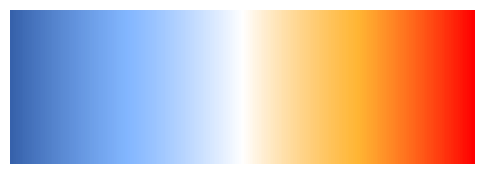

In [185]:
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


# gradient


# function for brain plot

In [86]:
# %%


def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: 
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(5000, 1000), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()


## stack xcorr data
previously, I had a bug where the dataframe was stacking sub-all.tsv. This led to an inflation in datapoints.
This bug is resolved by saving the file in a different folder, no longer being globbed and concatenated

In [219]:
xcorr_fname

'/Volumes/spacetop_projects_cue/analysis/physio/nobaseline/xcorr_canlab2023/sub-0031_ses-01_run-05_runtype-pain_xcorr-fmri-physio.tsv'

In [221]:
xcorr_dir = '/Volumes/spacetop_projects_cue/analysis/physio/nobaseline/xcorr_canlab2023'

all_frames = []  
xcorr_flist = glob.glob(join(xcorr_dir, f"sub-*_ses-*_run*_runtype-pain_xcorr-fmri-physio.tsv"))
for xcorr_fname in xcorr_flist:
# for filename in os.listdir(xcorr_dir):
    if xcorr_fname.endswith('.tsv'):  # Assuming the files are CSVs
        # file_path = os.path.join(xcorr_dir, filename)
        df = pd.read_csv(xcorr_fname, sep='\t')
        all_frames.append(df)
combined_df = pd.concat(all_frames, ignore_index=True)

from pathlib import Path
Path(join(xcorr_dir, 'total')).mkdir(exist_ok=True, parents=True)
combined_df.to_csv(join(xcorr_dir, 'total', 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t', index=False)

In [222]:
combined_df

Unnamed: 0       sub     ses     run    roi  \
0                0  sub-0061  ses-04  run-03    0.0   
1                1  sub-0061  ses-04  run-03    1.0   
2                2  sub-0061  ses-04  run-03    2.0   
3                3  sub-0061  ses-04  run-03    3.0   
4                4  sub-0061  ses-04  run-03    4.0   
...            ...       ...     ...     ...    ...   
146715         519  sub-0133  ses-01  run-03  519.0   
146716         520  sub-0133  ses-01  run-03  520.0   
146717         521  sub-0133  ses-01  run-03  521.0   
146718         522  sub-0133  ses-01  run-03  522.0   
146719         523  sub-0133  ses-01  run-03  523.0   

        Maximum Correlation Value  Time Lag (s)  
0                       -0.001571          4.60  
1                       -0.000834         -5.06  
2                       -0.000822          0.92  
3                       -0.002051          5.52  
4                        0.001245          8.74  
...                           ...           ...  
146715                   0.023252          0.92  
146716                  -0.026871         -2.76  
146717                   0.025781          0.00  
146718                  -0.014403          5.52  
146719                   0.016215         -1.38  

[146720 rows x 7 columns]

In [223]:
xcorr_dir = '/Volumes/spacetop_projects_cue/analysis/physio/nobaseline/xcorr_canlab2023'

combined_df = pd.read_csv(join(xcorr_dir, 'total', 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t')


In [224]:
combined_df.roi.unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [225]:
# remove unnecessary columns and rows with NA values
df = combined_df.drop(columns=['Unnamed: 0'])
df = df.dropna()
df.head()

sub     ses     run  roi  Maximum Correlation Value  Time Lag (s)
0  sub-0061  ses-04  run-03  0.0                  -0.001571          4.60
1  sub-0061  ses-04  run-03  1.0                  -0.000834         -5.06
2  sub-0061  ses-04  run-03  2.0                  -0.000822          0.92
3  sub-0061  ses-04  run-03  3.0                  -0.002051          5.52
4  sub-0061  ses-04  run-03  4.0                   0.001245          8.74

In [226]:
# Counting frequency of each 'sub' value
frequency = df.groupby('sub').size().reset_index(name='xcorr_frequency_including_400roi')
frequency['run_freq'] = frequency['xcorr_frequency_including_400roi'] / 524


In [227]:
sum(frequency.run_freq)/78

3.5792474065374833

In [228]:
frequency

sub  xcorr_frequency_including_400roi  run_freq
0   sub-0015                              1048       2.0
1   sub-0016                              2620       5.0
2   sub-0017                              1048       2.0
3   sub-0026                              1572       3.0
4   sub-0028                              1048       2.0
..       ...                               ...       ...
62  sub-0119                              1048       2.0
63  sub-0122                               524       1.0
64  sub-0131                              2096       4.0
65  sub-0132                              3144       6.0
66  sub-0133                              3144       6.0

[67 rows x 3 columns]

In [229]:
frequency.run_freq.min()

1.0

In [230]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10 

In [231]:
df.roi.unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

min: -0.2585070663459887, max:0.2595579677623038


Text(0.5, 1.0, 'Distribution of cross-correlation values\nMin: -0.259,  Max: 0.26')

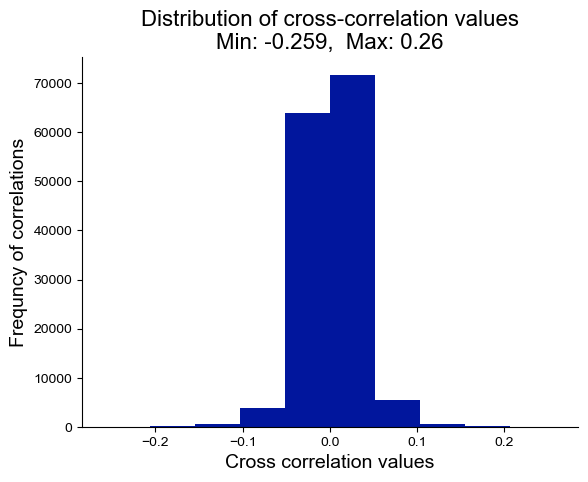

In [232]:
plt.hist(df['Maximum Correlation Value'], color='#01169D')
print(f"min: {df['Maximum Correlation Value'].min()}, max:{df['Maximum Correlation Value'].max()}")
sns.despine()
plt.xlabel('Cross correlation values', fontsize=14)
plt.ylabel('Frequncy of correlations', fontsize=14)
plt.title(f"Distribution of cross-correlation values\nMin: {round(df['Maximum Correlation Value'].min(), 3)},  Max: {round(df['Maximum Correlation Value'].max(), 3)}", fontsize=16)



## fisher z transform

In [233]:
def fisher_z_transform(r):
    return np.arctanh(r)

df['Max_Corr_Value_Z']  = df.groupby('sub')['Maximum Correlation Value'].transform(fisher_z_transform)
# df['Max_Corr_Value_Z'] = df['Maximum Correlation Value'].apply(fisher_z_transform)


In [234]:
df

sub     ses     run    roi  Maximum Correlation Value  \
0       sub-0061  ses-04  run-03    0.0                  -0.001571   
1       sub-0061  ses-04  run-03    1.0                  -0.000834   
2       sub-0061  ses-04  run-03    2.0                  -0.000822   
3       sub-0061  ses-04  run-03    3.0                  -0.002051   
4       sub-0061  ses-04  run-03    4.0                   0.001245   
...          ...     ...     ...    ...                        ...   
146715  sub-0133  ses-01  run-03  519.0                   0.023252   
146716  sub-0133  ses-01  run-03  520.0                  -0.026871   
146717  sub-0133  ses-01  run-03  521.0                   0.025781   
146718  sub-0133  ses-01  run-03  522.0                  -0.014403   
146719  sub-0133  ses-01  run-03  523.0                   0.016215   

        Time Lag (s)  Max_Corr_Value_Z  
0               4.60         -0.001571  
1              -5.06         -0.000834  
2               0.92         -0.000822  
3               5.52         -0.002051  
4               8.74          0.001245  
...              ...               ...  
146715          0.92          0.023256  
146716         -2.76         -0.026877  
146717          0.00          0.025786  
146718          5.52         -0.014404  
146719         -1.38          0.016216  

[146291 rows x 7 columns]

## calculate summary statistics
here, I average Maximum corr values, time lags 
* first by calculating 1) within runs, 
* then 2) aggregating corr values, time lags per roi averaged within subs, 
* then 3) group level stats per ROI

In [235]:
avg_per_ses = df.groupby(['sub', 'ses', 'roi']).agg({
    'Maximum Correlation Value': 'mean',
    'Time Lag (s)': 'mean',
    'Max_Corr_Value_Z': 'mean'
}).reset_index()


avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).agg({
    'Maximum Correlation Value': 'mean',
    'Time Lag (s)': 'mean',
    'Max_Corr_Value_Z': 'mean'
}).reset_index()

In [236]:
avg_per_sub

sub    roi  Maximum Correlation Value  Time Lag (s)  \
0      sub-0015    0.0                  -0.036365      5.520000   
1      sub-0015    1.0                  -0.031448      4.830000   
2      sub-0015    2.0                  -0.062211      4.140000   
3      sub-0015    3.0                  -0.044837      5.750000   
4      sub-0015    4.0                  -0.052130      4.140000   
...         ...    ...                        ...           ...   
35103  sub-0133  519.0                   0.020965      4.906667   
35104  sub-0133  520.0                  -0.011461      2.606667   
35105  sub-0133  521.0                   0.023133      5.290000   
35106  sub-0133  522.0                   0.007670      4.370000   
35107  sub-0133  523.0                   0.009875      3.756667   

       Max_Corr_Value_Z  
0             -0.036384  
1             -0.031520  
2             -0.062295  
3             -0.044868  
4             -0.052182  
...                 ...  
35103          0.020975  
35104         -0.011464  
35105          0.023159  
35106          0.007699  
35107          0.009881  

[35108 rows x 5 columns]

In [237]:
avg_per_sub

sub    roi  Maximum Correlation Value  Time Lag (s)  \
0      sub-0015    0.0                  -0.036365      5.520000   
1      sub-0015    1.0                  -0.031448      4.830000   
2      sub-0015    2.0                  -0.062211      4.140000   
3      sub-0015    3.0                  -0.044837      5.750000   
4      sub-0015    4.0                  -0.052130      4.140000   
...         ...    ...                        ...           ...   
35103  sub-0133  519.0                   0.020965      4.906667   
35104  sub-0133  520.0                  -0.011461      2.606667   
35105  sub-0133  521.0                   0.023133      5.290000   
35106  sub-0133  522.0                   0.007670      4.370000   
35107  sub-0133  523.0                   0.009875      3.756667   

       Max_Corr_Value_Z  
0             -0.036384  
1             -0.031520  
2             -0.062295  
3             -0.044868  
4             -0.052182  
...                 ...  
35103          0.020975  
35104         -0.011464  
35105          0.023159  
35106          0.007699  
35107          0.009881  

[35108 rows x 5 columns]

In [238]:
import pandas as pd
import scipy.stats

# Assuming df is your DataFrame

# Define a list to store the results
results = []

# Group by 'roi' and run t-test on each group
for roi, group in avg_per_sub.groupby('roi'):
    print(roi)
    # Extract the 'Maximum Correlation Value' for the current group
    values = group['Maximum Correlation Value']
    
    # Perform the one-sample t-test against the population mean of 0
    t, p = scipy.stats.ttest_1samp(values, popmean=0)
    
    # Append the results for the current ROI
    results.append({'roi': roi, 
    't-value': t, 
    'p-value': p, 
    'mean_xcor': np.tanh(np.nanmean(values, axis=0))
    })

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Show or save the results
print(results_df)


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


In [239]:
results

[{'roi': 0.0,
  't-value': 0.23653005046145348,
  'p-value': 0.8137539513013035,
  'mean_xcor': 0.0005792257786964984},
 {'roi': 1.0,
  't-value': 2.8418882022847747,
  'p-value': 0.005960585882735961,
  'mean_xcor': 0.006340880406911414},
 {'roi': 2.0,
  't-value': -0.167499471636912,
  'p-value': 0.8674892391162052,
  'mean_xcor': -0.0004039568273354067},
 {'roi': 3.0,
  't-value': -1.4234998172715736,
  'p-value': 0.159301638554873,
  'mean_xcor': -0.0034337801382929483},
 {'roi': 4.0,
  't-value': -1.0354989409094695,
  'p-value': 0.304215189036216,
  'mean_xcor': -0.002506099532093812},
 {'roi': 5.0,
  't-value': 3.0741560879124807,
  'p-value': 0.003068488062596171,
  'mean_xcor': 0.00827748316856507},
 {'roi': 6.0,
  't-value': 2.0106846328079286,
  'p-value': 0.048447368711969606,
  'mean_xcor': 0.005120354918352963},
 {'roi': 7.0,
  't-value': 1.2789985392968706,
  'p-value': 0.20537629805110263,
  'mean_xcor': 0.0027068027046355807},
 {'roi': 8.0,
  't-value': 1.5195948897214

In [240]:
# non_significant = results_df[results_df['p-value'] <= 0.05]
# non_significant
from statsmodels.stats.multitest import multipletests

p_adjusted = multipletests(results_df['p-value'], alpha=0.05, method='fdr_bh')
p_adjusted

(array([False,  True, False, False, False,  True, False, False, False,
        False,  True, False, False, False, False,  True,  True,  True,
         True, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
      

In [241]:
adjusted_p_values = p_adjusted[2]
adjusted_p_values

9.788317551784331e-05

In [242]:
df.columns

Index(['sub', 'ses', 'run', 'roi', 'Maximum Correlation Value', 'Time Lag (s)',
       'Max_Corr_Value_Z'],
      dtype='object')

In [243]:
group_level_avg

roi  Maximum Correlation Value  Time Lag (s)  Max_Corr_Value_Z  \
0      0.0                   0.000638      5.429030          0.000632   
1      1.0                   0.006578      5.070871          0.006597   
2      2.0                  -0.000628      5.230498         -0.000629   
3      3.0                  -0.003326      5.292289         -0.003337   
4      4.0                  -0.002462      5.283706         -0.002473   
..     ...                        ...           ...               ...   
581  581.0                  -0.000508      5.179259         -0.000505   
582  582.0                   0.006290      6.120556          0.006294   
583  583.0                   0.004874      4.953519          0.004880   
584  584.0                  -0.002861      4.203889         -0.002863   
585  585.0                  -0.002606      4.570185         -0.002606   

     Avg_Max_Corr_Value  
0              0.000632  
1              0.006597  
2             -0.000629  
3             -0.003337  
4             -0.002473  
..                  ...  
581           -0.000505  
582            0.006294  
583            0.004880  
584           -0.002863  
585           -0.002606  

[586 rows x 5 columns]

In [244]:

group_level_avg = avg_per_sub.groupby('roi').agg({
    'Maximum Correlation Value': 'mean',
    'Time Lag (s)': 'mean',
    'Max_Corr_Value_Z': 'mean'
    }).reset_index()
group_level_avg['Avg_Max_Corr_Value'] = np.tanh(group_level_avg['Max_Corr_Value_Z'])
xcorr_stat = group_level_avg.merge(results_df, how='inner', on='roi')

## subjectwise T

In [245]:
subjectwise_results = []
for (roi, subject), group in df.groupby(['roi', 'sub']):
    values = group['Maximum Correlation Value'].values
    
    t, p = scipy.stats.ttest_1samp(values, popmean=0)
    # if roi not in t_map:
    #     t_map[roi] = {}
    #     p_map[roi] = {}
    
    subjectwise_results.append({
        'sub':subject,
        'roi': roi, 
    't-value': t, 
    'p-value': p, 
    'mean_xcor': np.tanh(np.nanmean(values, axis=0))
    })
subjectwise_results_df = pd.DataFrame(subjectwise_results)
subjectwise_clean = subjectwise_results_df.dropna()



/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [246]:
import numpy as np
import pandas as pd
import scipy.stats

# Group by ROI and calculate mean of the 'Maximum Correlation Value'
group_means = subjectwise_clean.groupby('roi')['mean_xcor'].mean().reset_index()

# Initialize list to hold group-level t and p values
group_level_stats = []

# Perform a one-sample t-test for the group mean against the population mean (0) for each ROI
for index, row in group_means.iterrows():
    # Assuming you're testing against a population mean of 0
    t, p = scipy.stats.ttest_1samp(subjectwise_clean[subjectwise_clean['roi'] == row['roi']]['mean_xcor'], 0)
    
    # Append group-level stats
    group_level_stats.append({'roi': row['roi'], 't-value': t, 'p-value': p, 'mean_xcorr': row['mean_xcor']})

# Convert to DataFrame
group_level_stats_df = pd.DataFrame(group_level_stats)


# multiple comparisons
from statsmodels.stats.multitest import multipletests

# Extract p-values
p_values = group_level_stats_df['p-value'].values

# Apply Benjamini-Hochberg FDR correction
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Add corrected p-values to the DataFrame
group_level_stats_df['corrected_p-value'] = corrected_p_values
np.sum(group_level_stats_df['corrected_p-value'] < .05)
group_level_stats_df.head()
group_level_stats_df['Time Lag (s)'] = group_level_avg['Time Lag (s)']


In [247]:
group_level_stats_df

roi   t-value   p-value  mean_xcorr  corrected_p-value  Time Lag (s)
0      0.0  0.410817  0.682579    0.001030           0.839791      5.425597
1      1.0  2.580443  0.012172    0.005929           0.076842      5.043408
2      2.0  0.029847  0.976282    0.000074           0.992744      5.233930
3      3.0 -1.164310  0.248620   -0.002863           0.474274      5.257960
4      4.0 -0.855270  0.395592   -0.002096           0.599362      5.210473
..     ...       ...       ...         ...                ...           ...
519  519.0  2.315715  0.023790    0.004223           0.124659      4.887214
520  520.0  1.026506  0.308517    0.001737           0.538913      5.001070
521  521.0  3.617711  0.000587    0.006417           0.008094      5.086891
522  522.0  1.910811  0.060510    0.004314           0.221730      5.109776
523  523.0  0.280702  0.779845    0.000469           0.892224      4.912960

[524 rows x 6 columns]

## plot

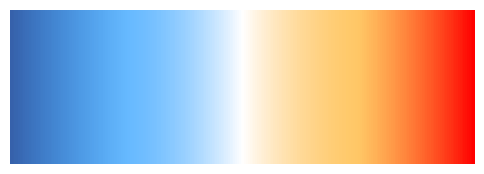

In [248]:
# Define the colors at specific points
colors = [
    (-0.01, "#120041"),  # Start with blue at -1.9
    (-0.005, "#2500fa"),
    (-0.001, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.001, "#d50044"),
    (0.005, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (0.010, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-0.010, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-0.005, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    (-0.001, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    (0.001, to_rgba("#ffa300", alpha=0.6)),   # 30% opacity
    # (0.005, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (0.010, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, .064, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
xcorr_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=xcorr_cmap)
ax.set_axis_off()

plt.show()


In [249]:
group_level_avg

roi  Maximum Correlation Value  Time Lag (s)  Max_Corr_Value_Z  \
0      0.0                   0.000579      5.425597          0.000573   
1      1.0                   0.006341      5.043408          0.006360   
2      2.0                  -0.000404      5.233930         -0.000405   
3      3.0                  -0.003434      5.257960         -0.003446   
4      4.0                  -0.002506      5.210473         -0.002517   
..     ...                        ...           ...               ...   
519  519.0                   0.004069      4.887214          0.004074   
520  520.0                   0.002082      5.001070          0.002090   
521  521.0                   0.005938      5.086891          0.005948   
522  522.0                   0.004091      5.109776          0.004117   
523  523.0                   0.000298      4.912960          0.000300   

     Avg_Max_Corr_Value  
0              0.000573  
1              0.006360  
2             -0.000405  
3             -0.003446  
4             -0.002517  
..                  ...  
519            0.004074  
520            0.002090  
521            0.005948  
522            0.004117  
523            0.000300  

[524 rows x 5 columns]

# plot X corr

In [250]:
group_level_stats_df

roi   t-value   p-value  mean_xcorr  corrected_p-value  Time Lag (s)
0      0.0  0.410817  0.682579    0.001030           0.839791      5.425597
1      1.0  2.580443  0.012172    0.005929           0.076842      5.043408
2      2.0  0.029847  0.976282    0.000074           0.992744      5.233930
3      3.0 -1.164310  0.248620   -0.002863           0.474274      5.257960
4      4.0 -0.855270  0.395592   -0.002096           0.599362      5.210473
..     ...       ...       ...         ...                ...           ...
519  519.0  2.315715  0.023790    0.004223           0.124659      4.887214
520  520.0  1.026506  0.308517    0.001737           0.538913      5.001070
521  521.0  3.617711  0.000587    0.006417           0.008094      5.086891
522  522.0  1.910811  0.060510    0.004314           0.221730      5.109776
523  523.0  0.280702  0.779845    0.000469           0.892224      4.912960

[524 rows x 6 columns]

In [251]:
group_level_stats_df['xcorr_sig'] = np.where(group_level_stats_df['corrected_p-value'] < .05, group_level_stats_df['mean_xcorr'], np.nan)
group_level_stats_df['xcorr_sig'].head()
np.sum(group_level_stats_df['xcorr_sig'])

0.5728045379251058

In [252]:
np.sum(group_level_stats_df['xcorr_sig'])

0.5728045379251058

In [127]:
canlab2023 = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.nii.gz'
canlab2023_list = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.csv'
canlab2023_parcel = pd.read_csv(canlab2023_list)
parc = Parcellater(parcellation=canlab2023, 
                   space='MNI152',
                   resampling_target='parcellation')

In [253]:
canlab2023_parcel.shape

(524, 5)

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


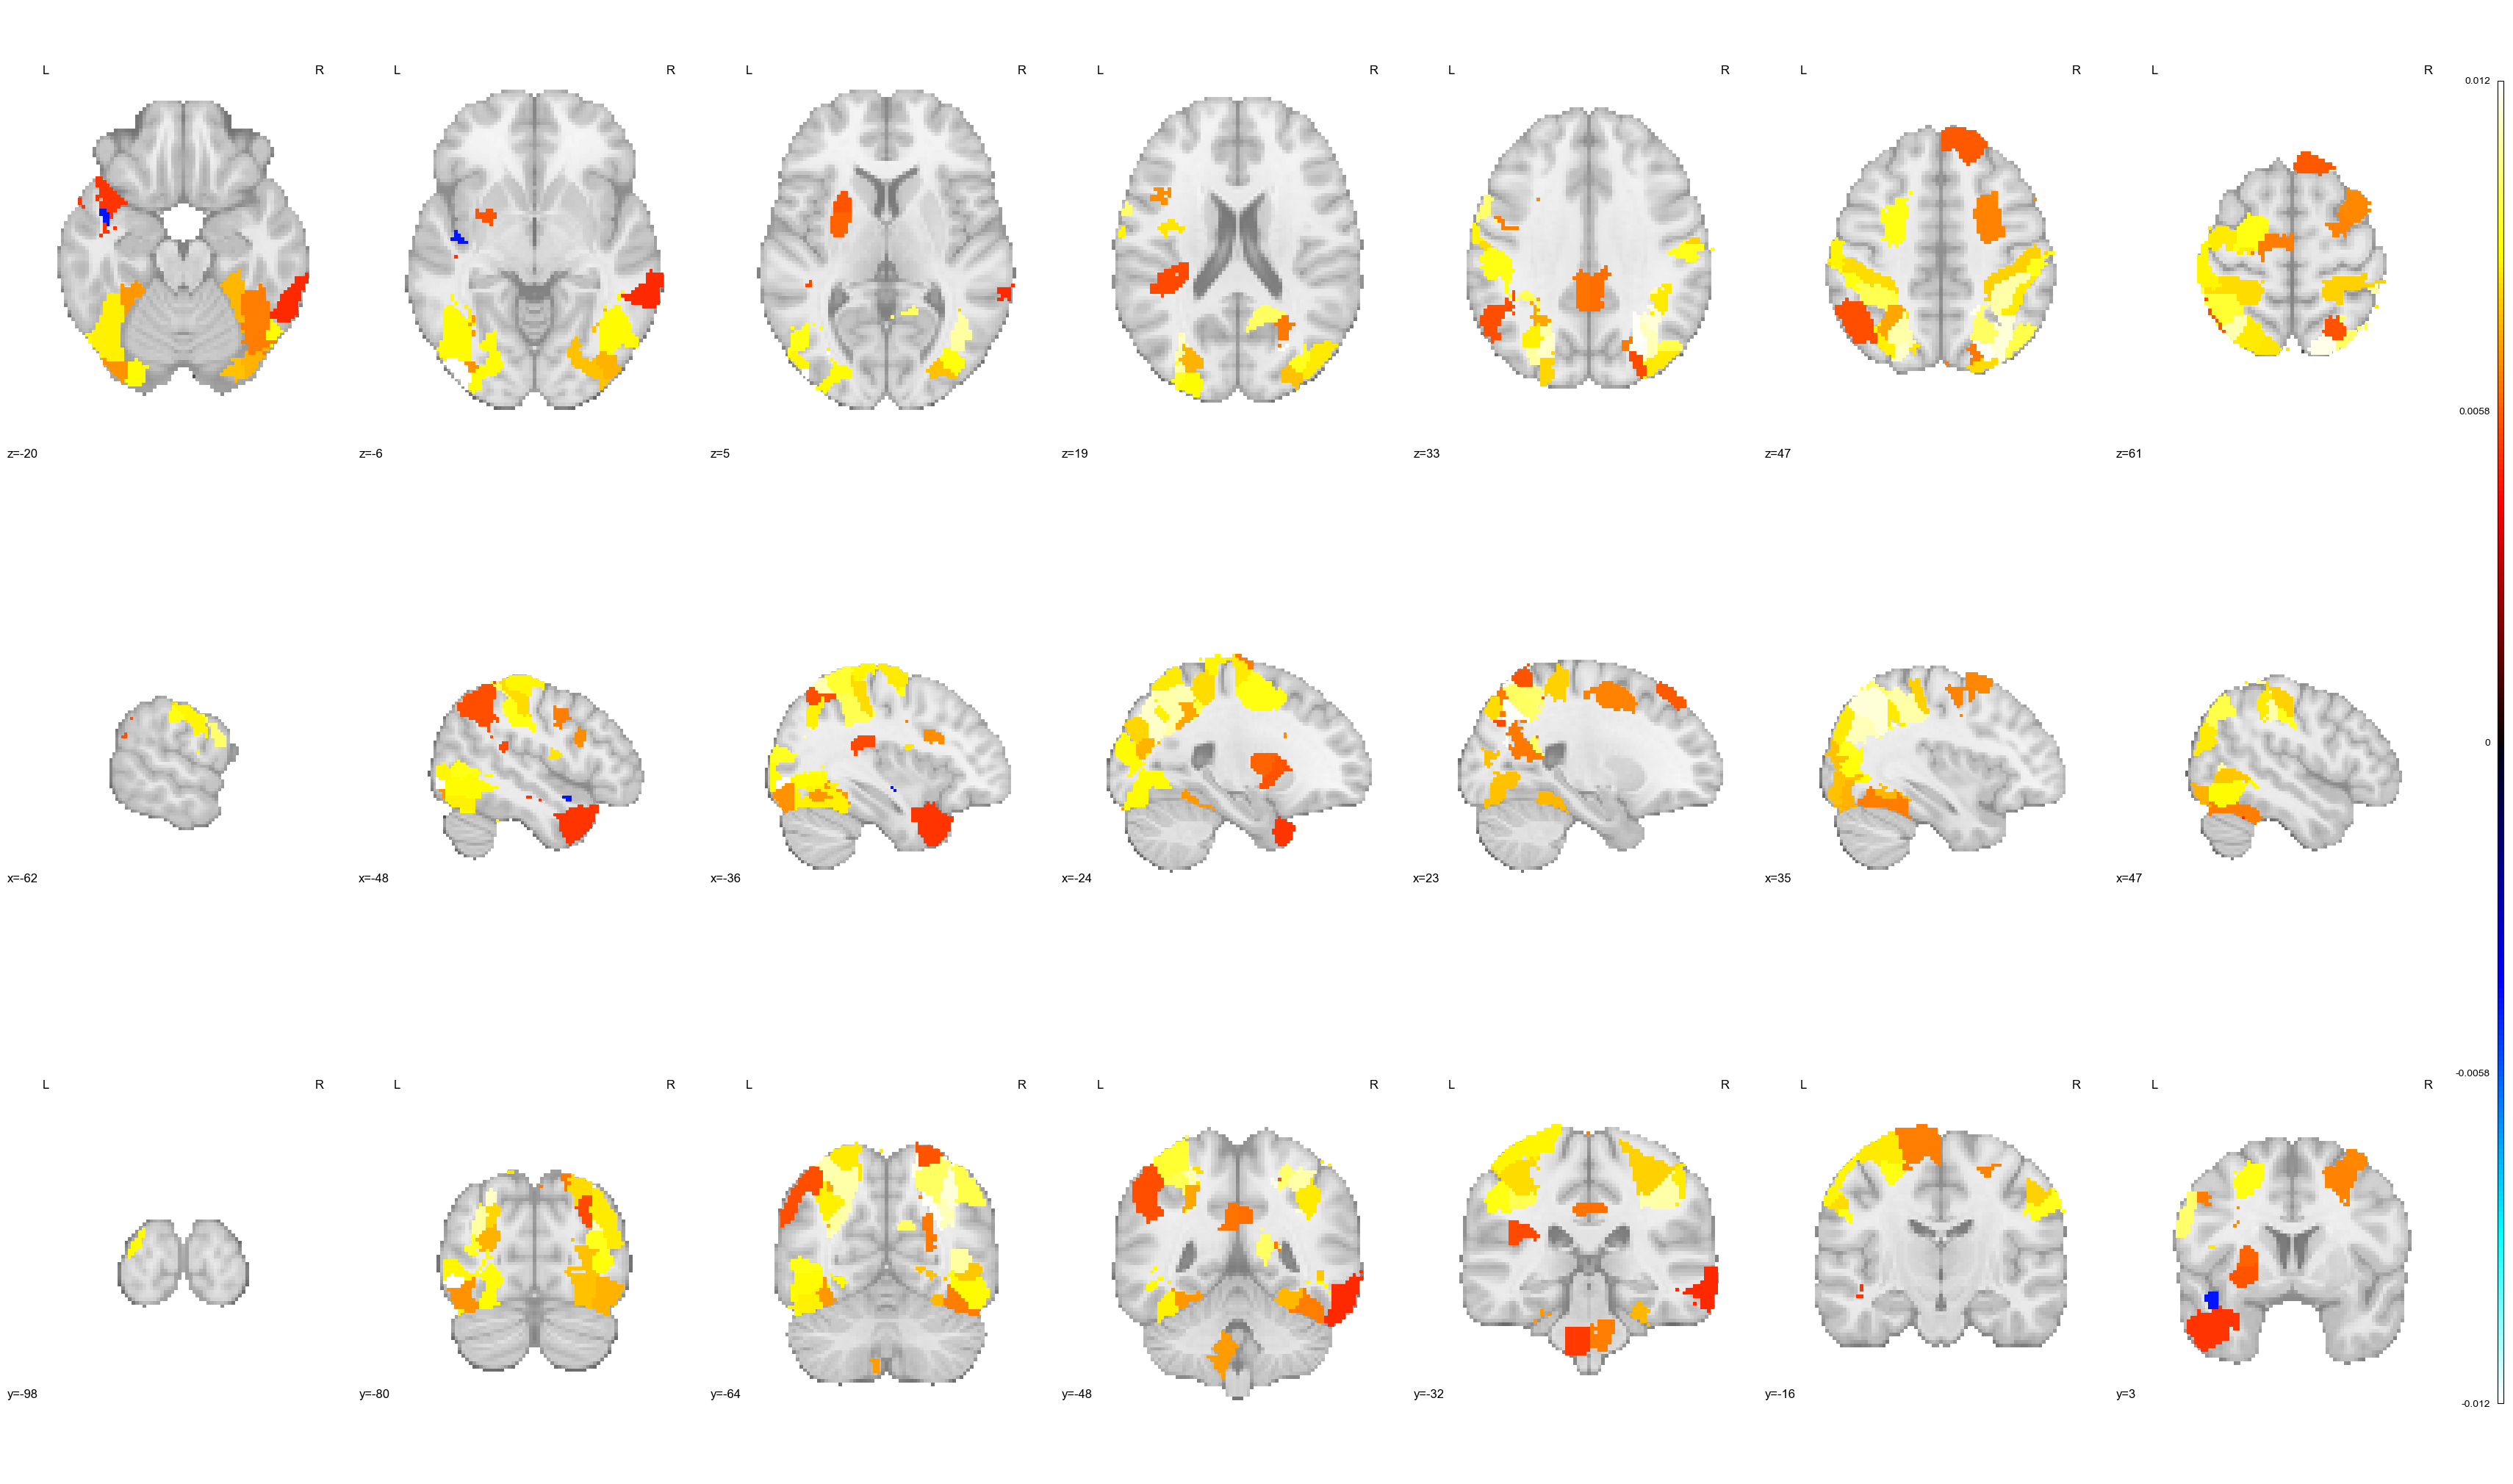

<Figure size 640x480 with 0 Axes>

In [256]:

# parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_xcorr = group_level_stats_df['xcorr_sig']
roimni = parc.inverse_transform(roi_xcorr)

maxval = np.max(roi_xcorr);    minval = np.min(roi_xcorr); sd = np.std(roi_xcorr)
plotting.plot_stat_map(roimni, display_mode='mosaic')
# fig = plot_brain_surfaces(image=roidata, cbar_label='Cross-correlation values', cmap=xcorr_cmap, color_range=(minval, maxval))
plt.show()
plt.savefig('Xcorr.png', dpi=300)  # Increase DPI for higher resolution


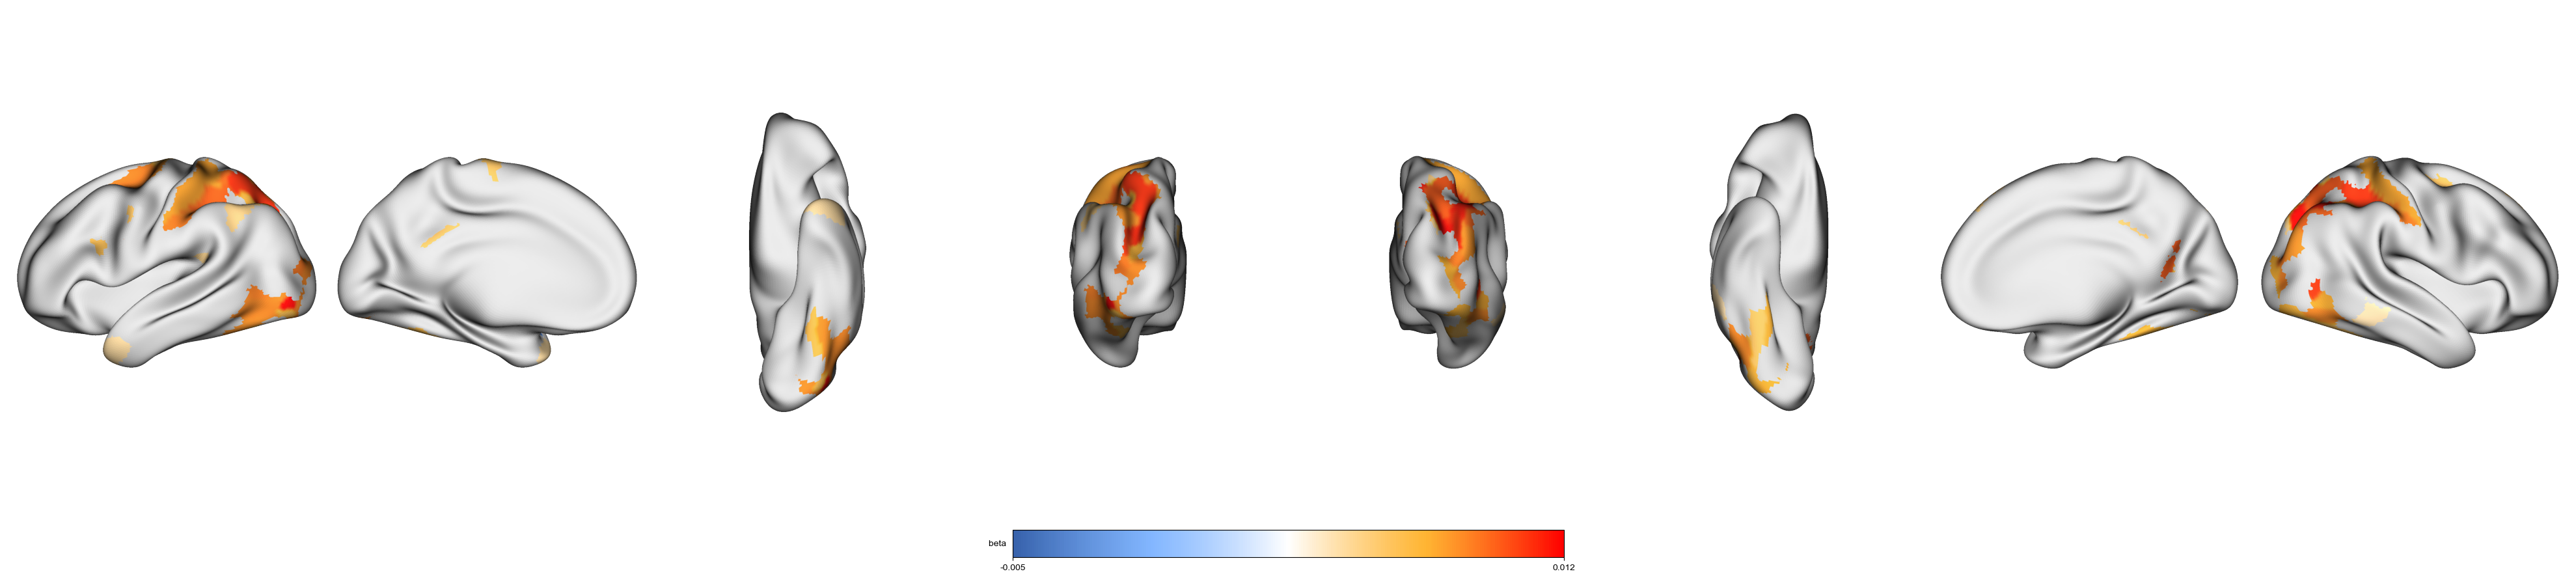

In [317]:
from neuromaps.transforms import mni152_to_fslr
canlab2023_ctx = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm_cortex.nii.gz'
canlab2023_list = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.csv'
canlab2023_parcel = pd.read_csv(canlab2023_list)
parc_ctx = Parcellater(parcellation=canlab2023_ctx, 
                   space='MNI152')
                   #resampling_target='parcellation')
roi_xcorr = group_level_stats_df['xcorr_sig']
roictx = parc_ctx.inverse_transform(roi_xcorr)

# join(atlas_dir, 'CANLab2023_MNI152NLin2009cAsym_coarse_2mm_cortex.nii.gz')
beta_fslr = mni152_to_fslr(
        roictx, fslr_density='32k', method='linear')
fig = plot_brain_surfaces(image=beta_fslr, cbar_label=f'beta ', cmap=cmap)#color_range[beta_ind])
plt.show()

min: -0.004564270017894217, max:0.011669880300680198


Text(0.5, 1.0, 'Distribution of cross-correlation values (summary statistics)\nMin: -0.005,  Max: 0.012')

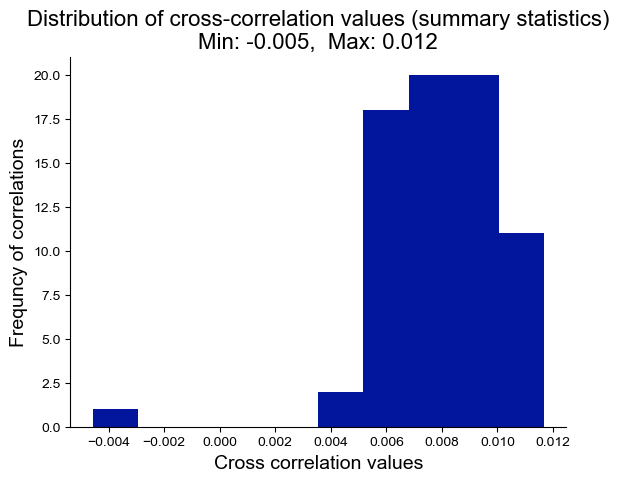

In [318]:
plt.hist(roi_xcorr)
plt.hist(roi_xcorr, color='#01169D')
print(f"min: {roi_xcorr.min()}, max:{roi_xcorr.max()}")
sns.despine()
plt.xlabel('Cross correlation values', fontsize=14)
plt.ylabel('Frequncy of correlations', fontsize=14)
plt.title(f"Distribution of cross-correlation values (summary statistics)\nMin: {round(roi_xcorr.min(), 3)},  Max: {round(roi_xcorr.max(), 3)}", fontsize=16)



sandbox

In [319]:
group_level_stats_df['xcorr_sig'][:358]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
353   NaN
354   NaN
355   NaN
356   NaN
357   NaN
Name: xcorr_sig, Length: 358, dtype: float64

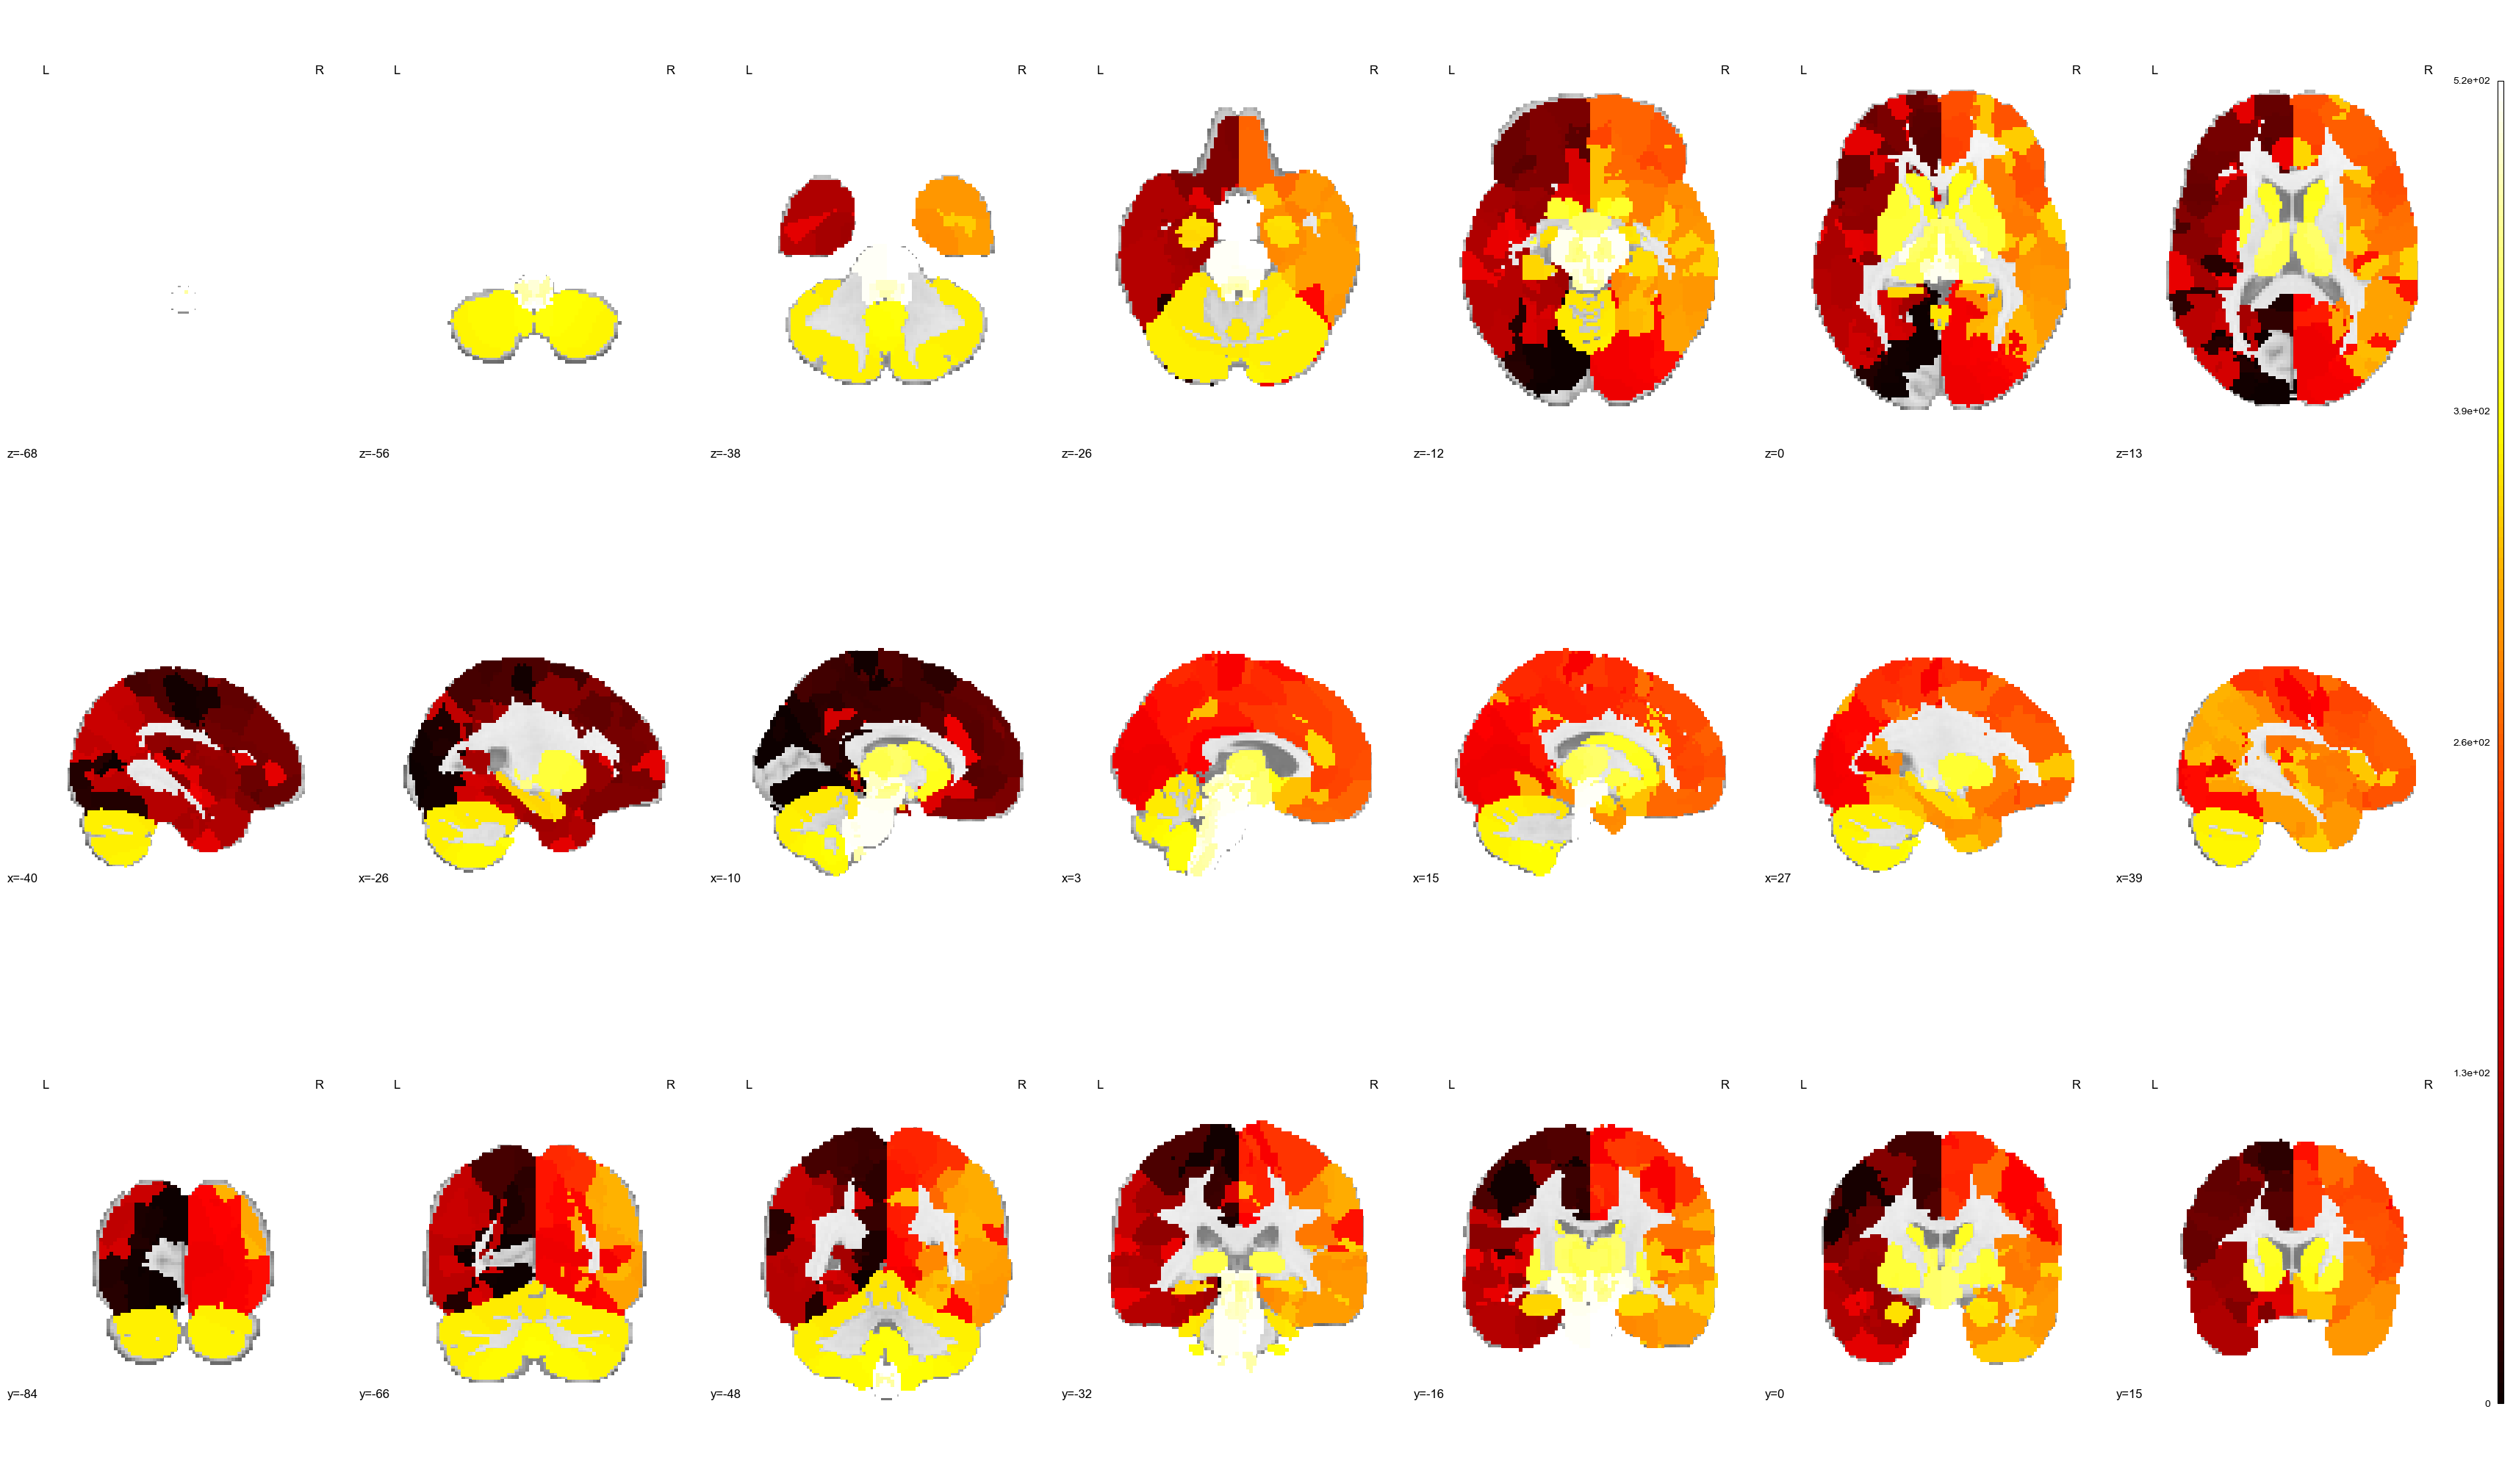

In [352]:
canlab2023 = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.nii.gz'
atlas = image.load_img(canlab2023)
# atlas
# parc = Parcellater(parcellation=atlas, 
#                    space='MNI152',
#                    resampling_target='parcellation')
# roimni = parc.inverse_transform(np.arange(526))
plotting.plot_stat_map(roimni, display_mode='mosaic')

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/regions/signal_extraction.py:421: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(labels_img, data, labels_img.affine)


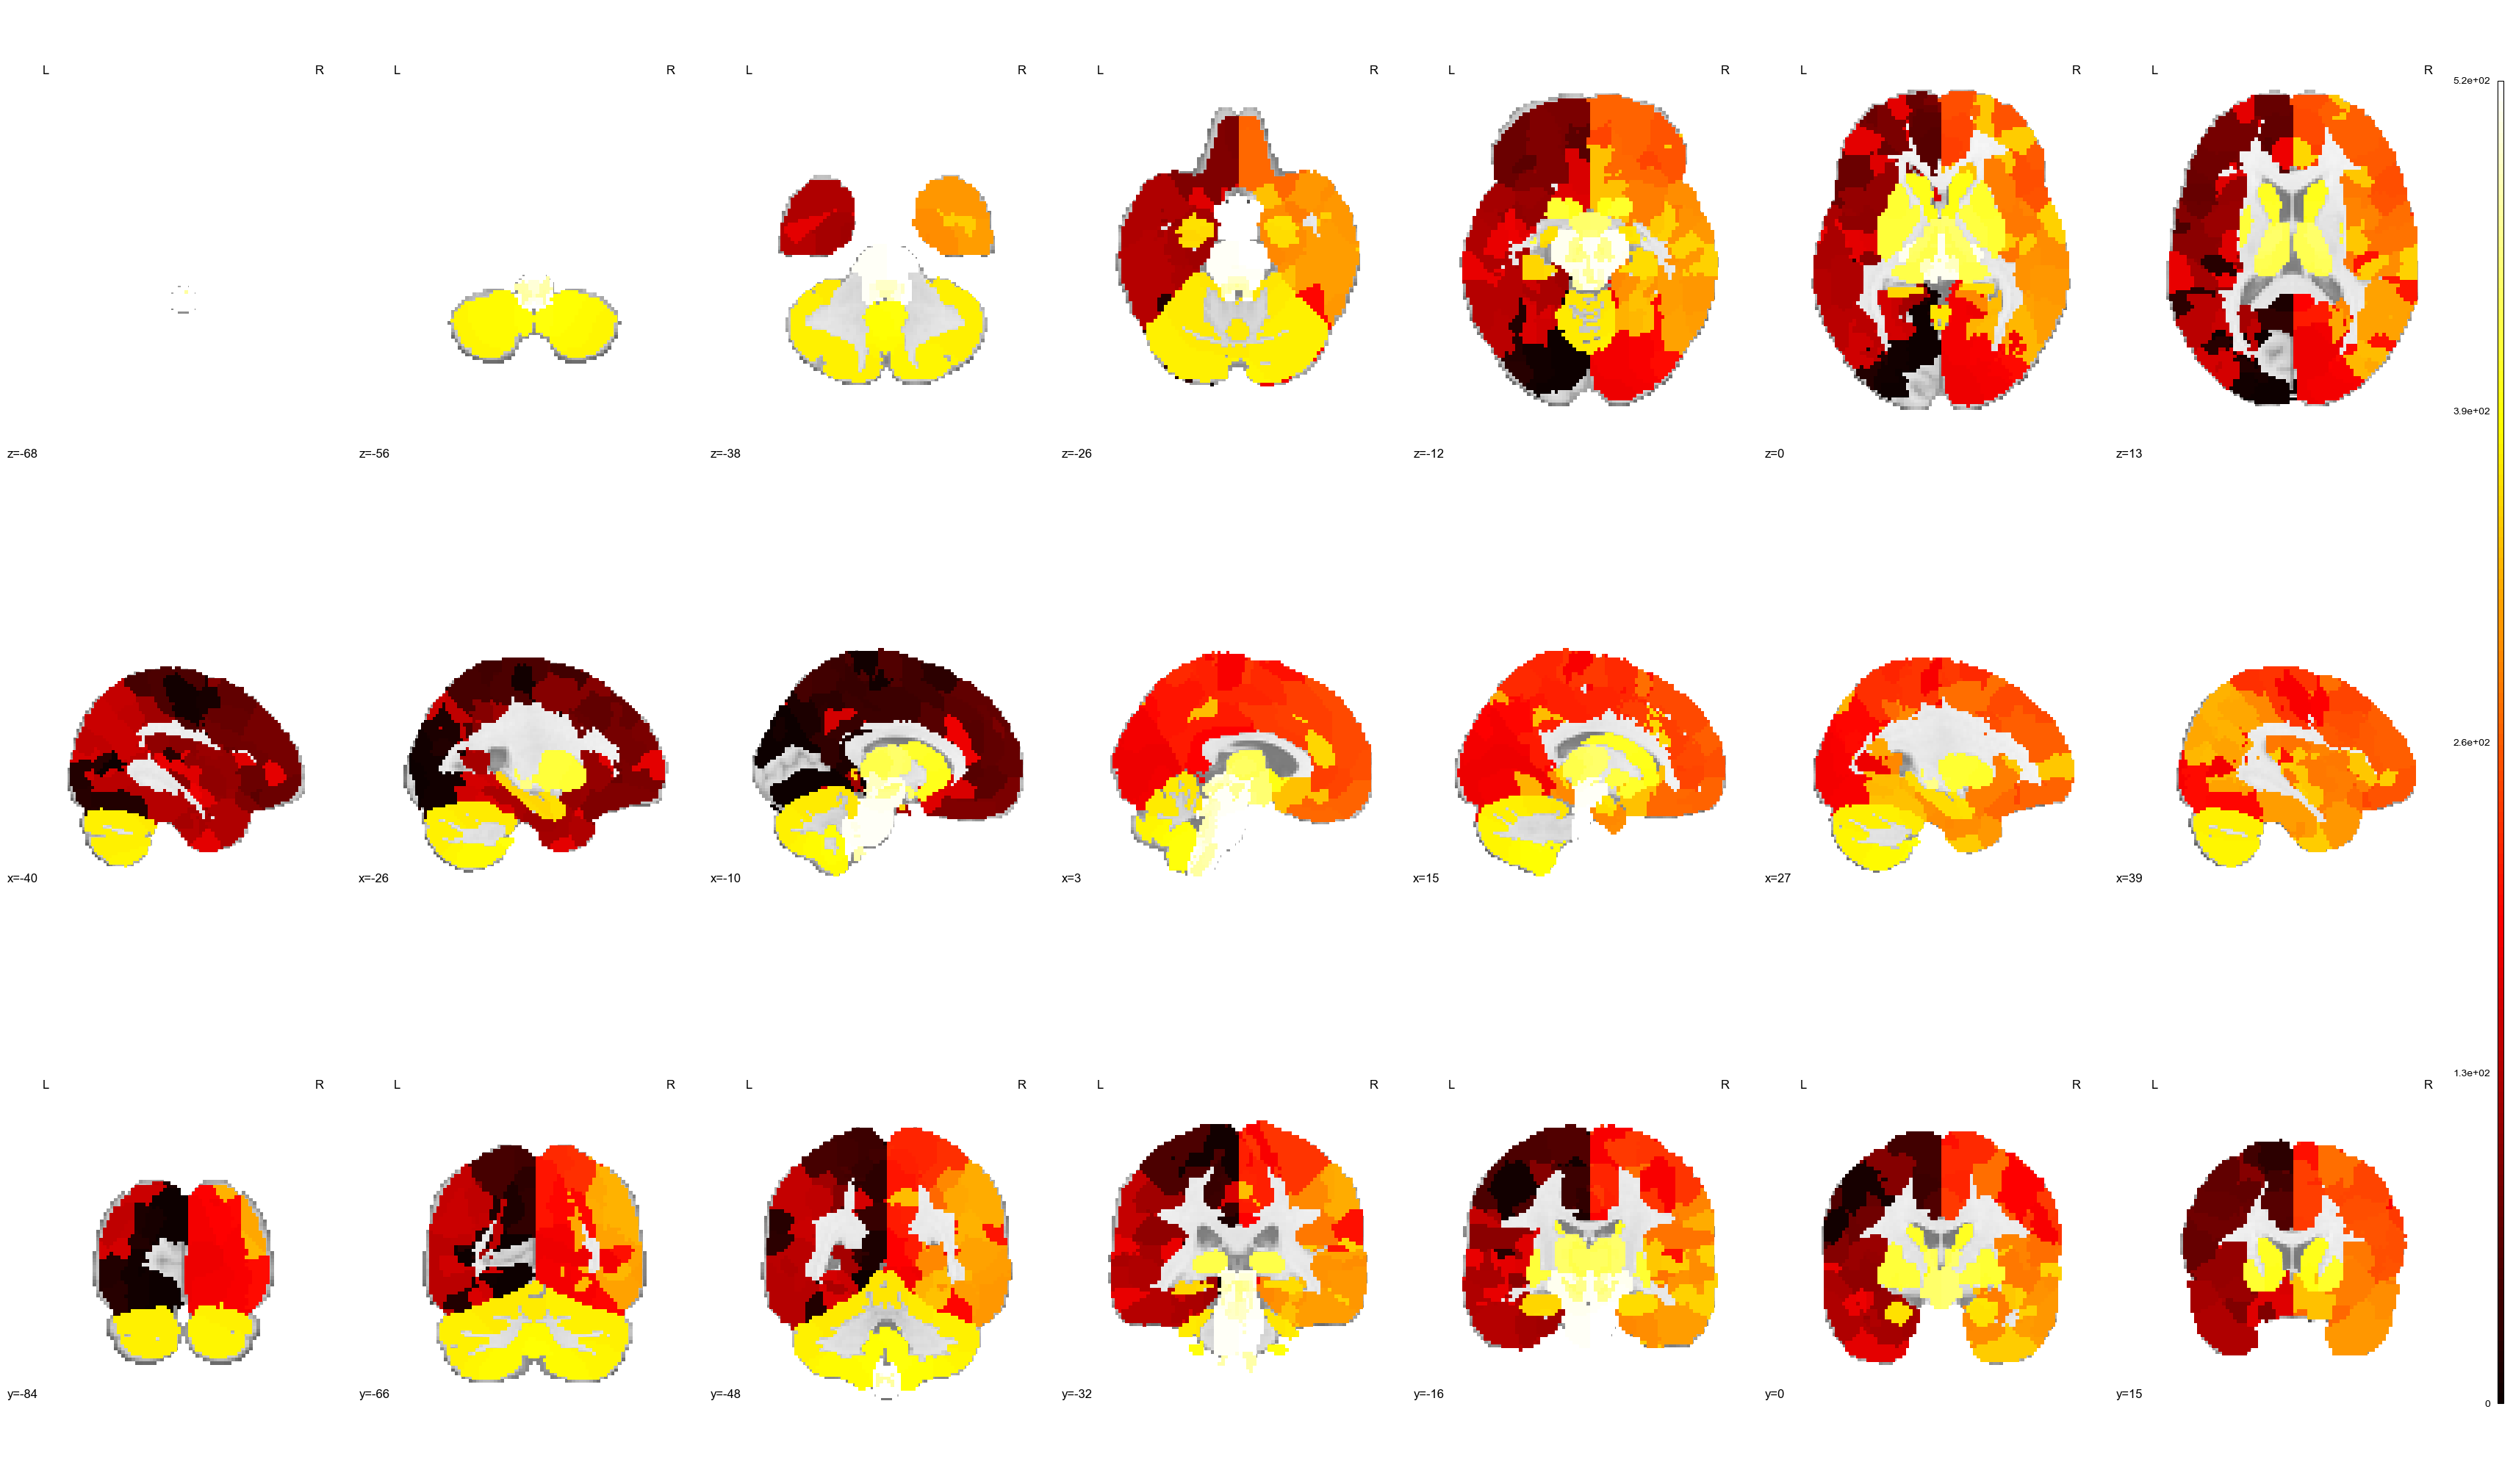

IndexError: index 522 is out of bounds for axis 1 with size 360

<Figure size 640x480 with 0 Axes>

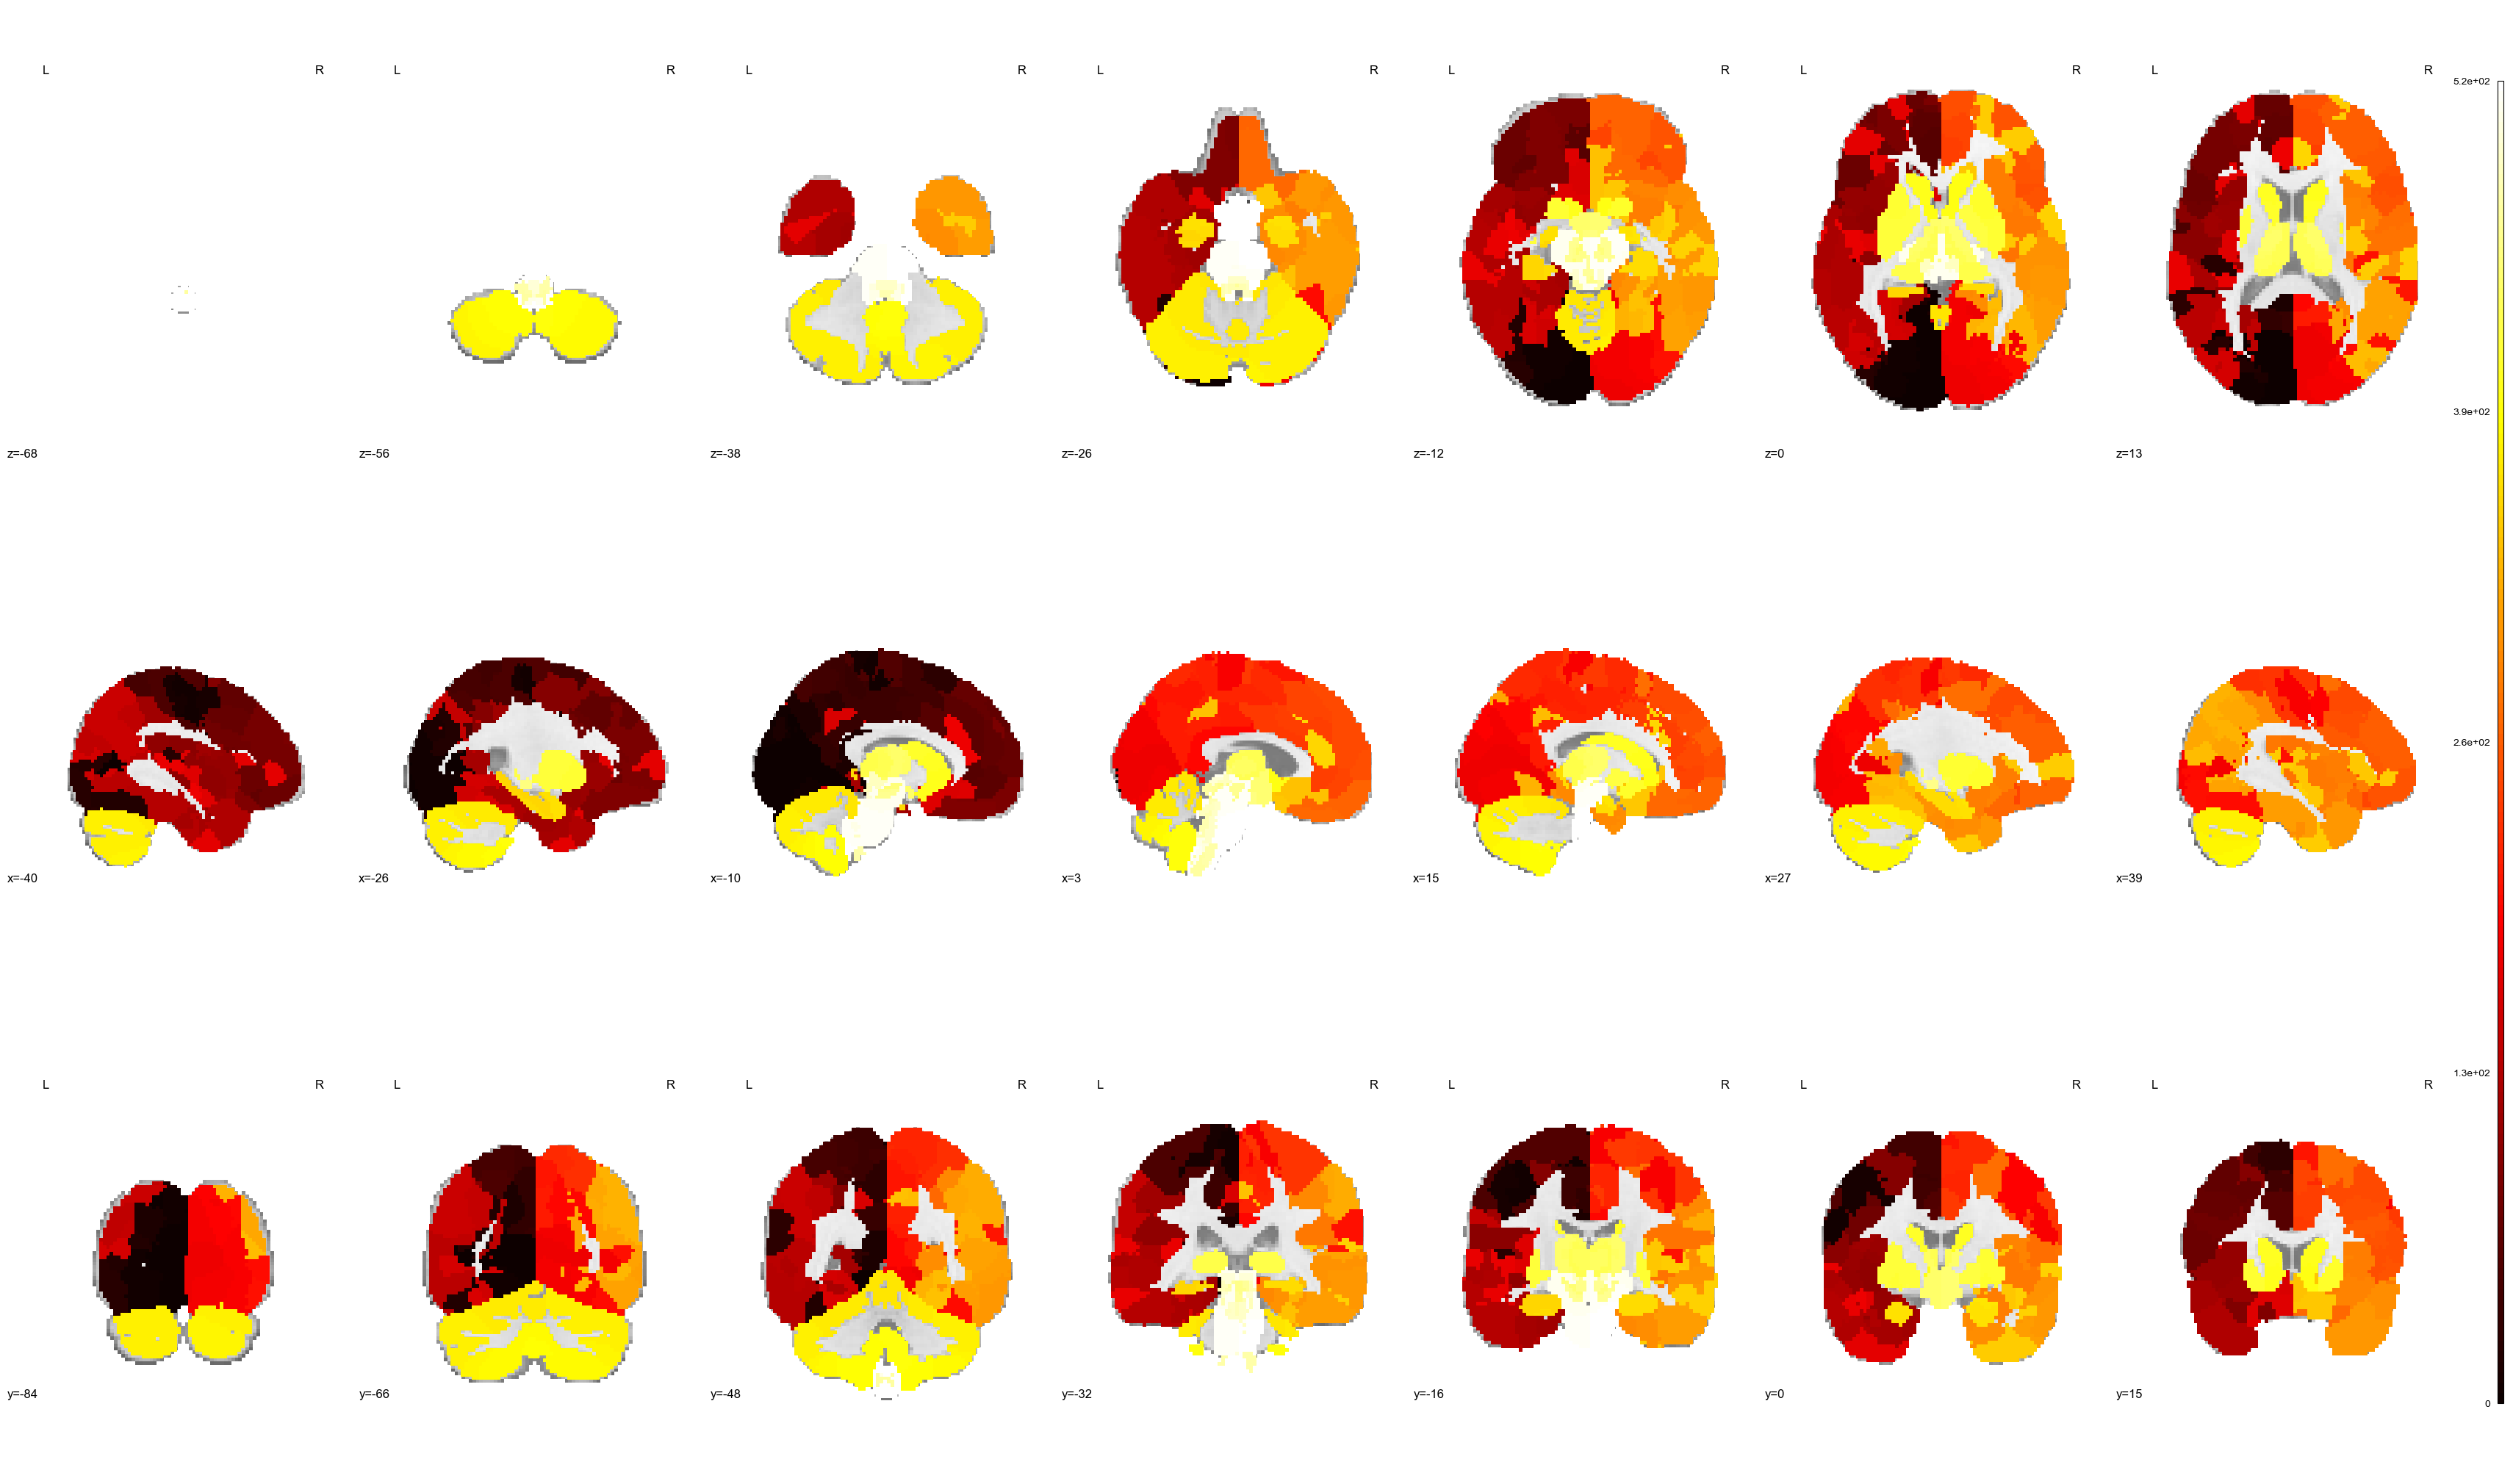

In [349]:

# parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_xcorr = group_level_stats_df['xcorr_sig']
roi_xcorr = np.arange(526)
parc = Parcellater(parcellation=atlas, 
                   space='MNI152',
                   resampling_target='parcellation')
roimni = parc.inverse_transform(roi_xcorr)

maxval = np.max(roi_xcorr);    minval = np.min(roi_xcorr); sd = np.std(roi_xcorr)
plotting.plot_stat_map(roimni, display_mode='mosaic')
# fig = plot_brain_surfaces(image=roidata, cbar_label='Cross-correlation values', cmap=xcorr_cmap, color_range=(minval, maxval))
plt.show()
plt.savefig('Xcorr.png', dpi=300)  # Increase DPI for higher resolution


# back to surface 
############# cortex #######
# plot_color_gradients['prism']
# convert to fslr
# beta_fslr = 
from neuromaps.transforms import mni152_to_fslr
canlab2023 = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.nii.gz'
canlab2023_list = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.csv'
canlab2023_parcel = pd.read_csv(canlab2023_list)
parc_ctx = Parcellater(parcellation=canlab2023, 
                   space='MNI152',
                   resampling_target='parcellation')
plotting.plot_stat_map(canlab2023, display_mode='mosaic')
roi_xcorr = group_level_stats_df['xcorr_sig'][:358]
roi_xcorr = np.array(np.arange(360))
roictx = parc_ctx.inverse_transform(roi_xcorr)
print(f"{roictx.shape}")
# join(atlas_dir, 'CANLab2023_MNI152NLin2009cAsym_coarse_2mm_cortex.nii.gz')
beta_fslr = mni152_to_fslr(
        roictx, fslr_density='32k', method='nearest')
fig = plot_brain_surfaces(image=beta_fslr, cbar_label=f'beta ', cmap='prism')#color_range[beta_ind])
plt.show()

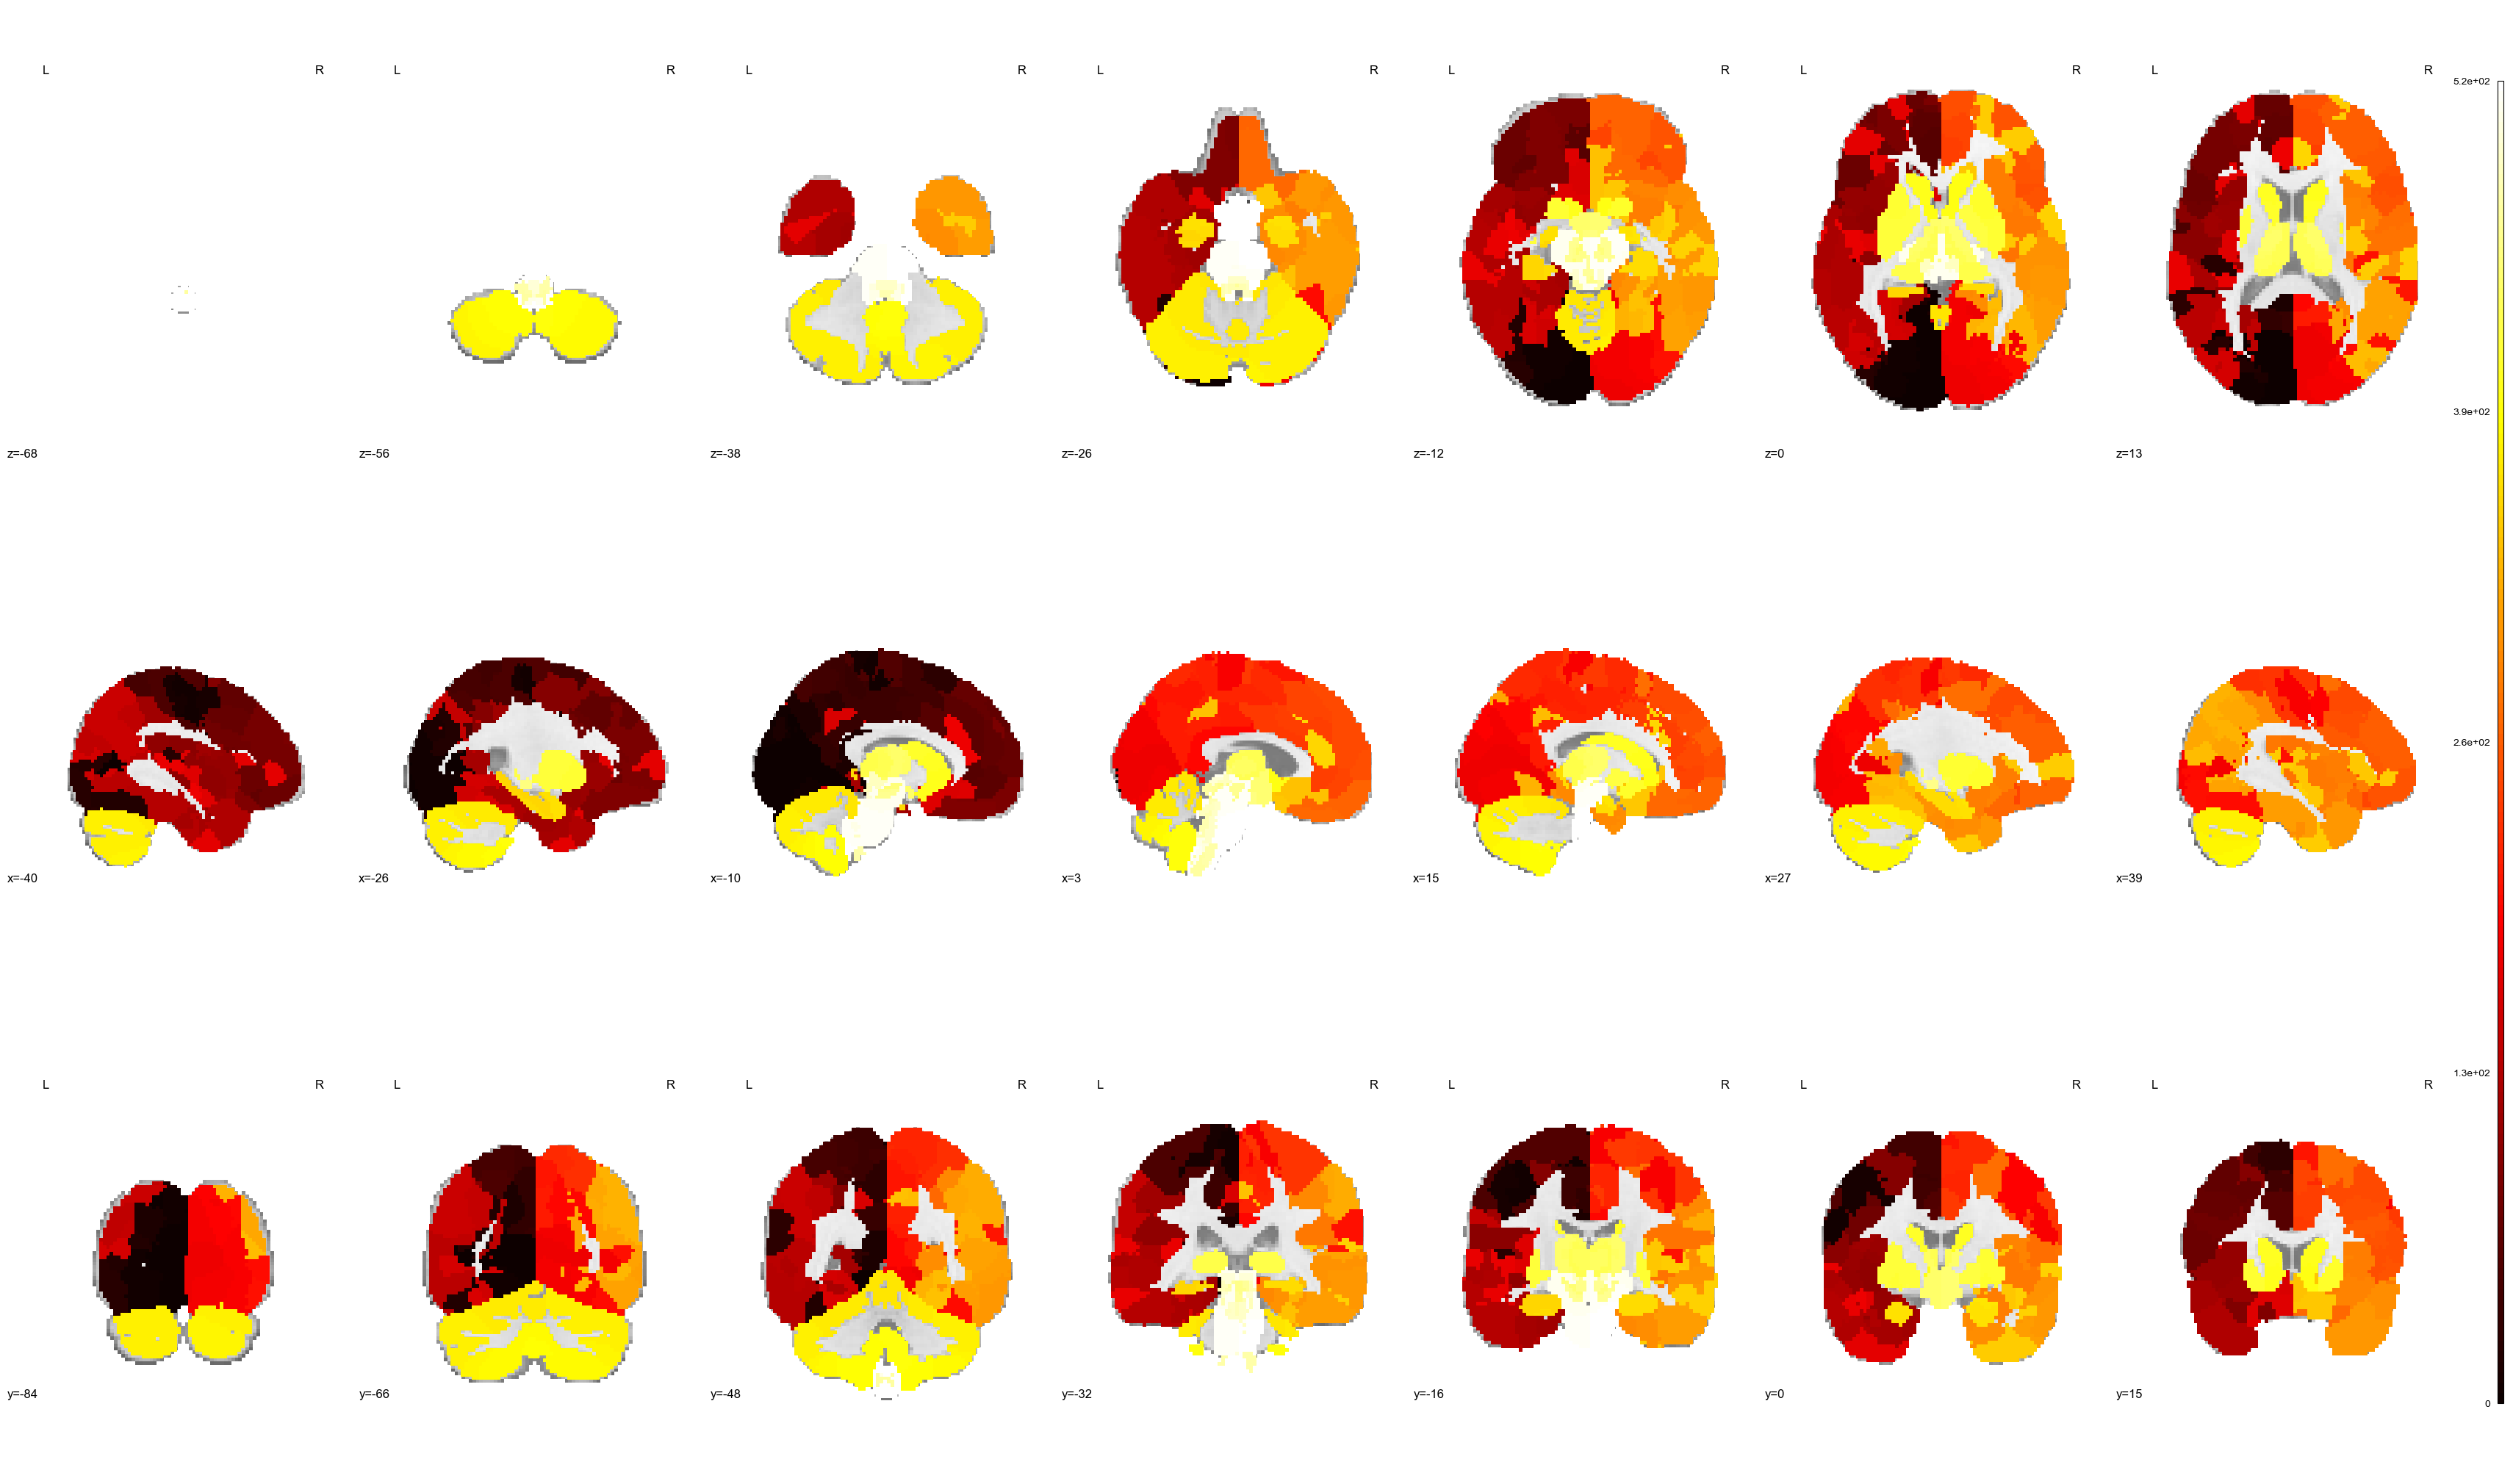

In [340]:
plotting.plot_stat_map('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.nii.gz', display_mode='mosaic')

In [332]:
group_level_stats_df

roi   t-value   p-value  mean_xcorr  corrected_p-value  Time Lag (s)  \
0      0.0  0.410817  0.682579    0.001030           0.839791      5.425597   
1      1.0  2.580443  0.012172    0.005929           0.076842      5.043408   
2      2.0  0.029847  0.976282    0.000074           0.992744      5.233930   
3      3.0 -1.164310  0.248620   -0.002863           0.474274      5.257960   
4      4.0 -0.855270  0.395592   -0.002096           0.599362      5.210473   
..     ...       ...       ...         ...                ...           ...   
519  519.0  2.315715  0.023790    0.004223           0.124659      4.887214   
520  520.0  1.026506  0.308517    0.001737           0.538913      5.001070   
521  521.0  3.617711  0.000587    0.006417           0.008094      5.086891   
522  522.0  1.910811  0.060510    0.004314           0.221730      5.109776   
523  523.0  0.280702  0.779845    0.000469           0.892224      4.912960   

     xcorr_sig   lag_sig  
0          NaN       NaN  
1          NaN       NaN  
2          NaN       NaN  
3          NaN       NaN  
4          NaN       NaN  
..         ...       ...  
519        NaN       NaN  
520        NaN       NaN  
521   0.006417  5.086891  
522        NaN       NaN  
523        NaN       NaN  

[524 rows x 8 columns]

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


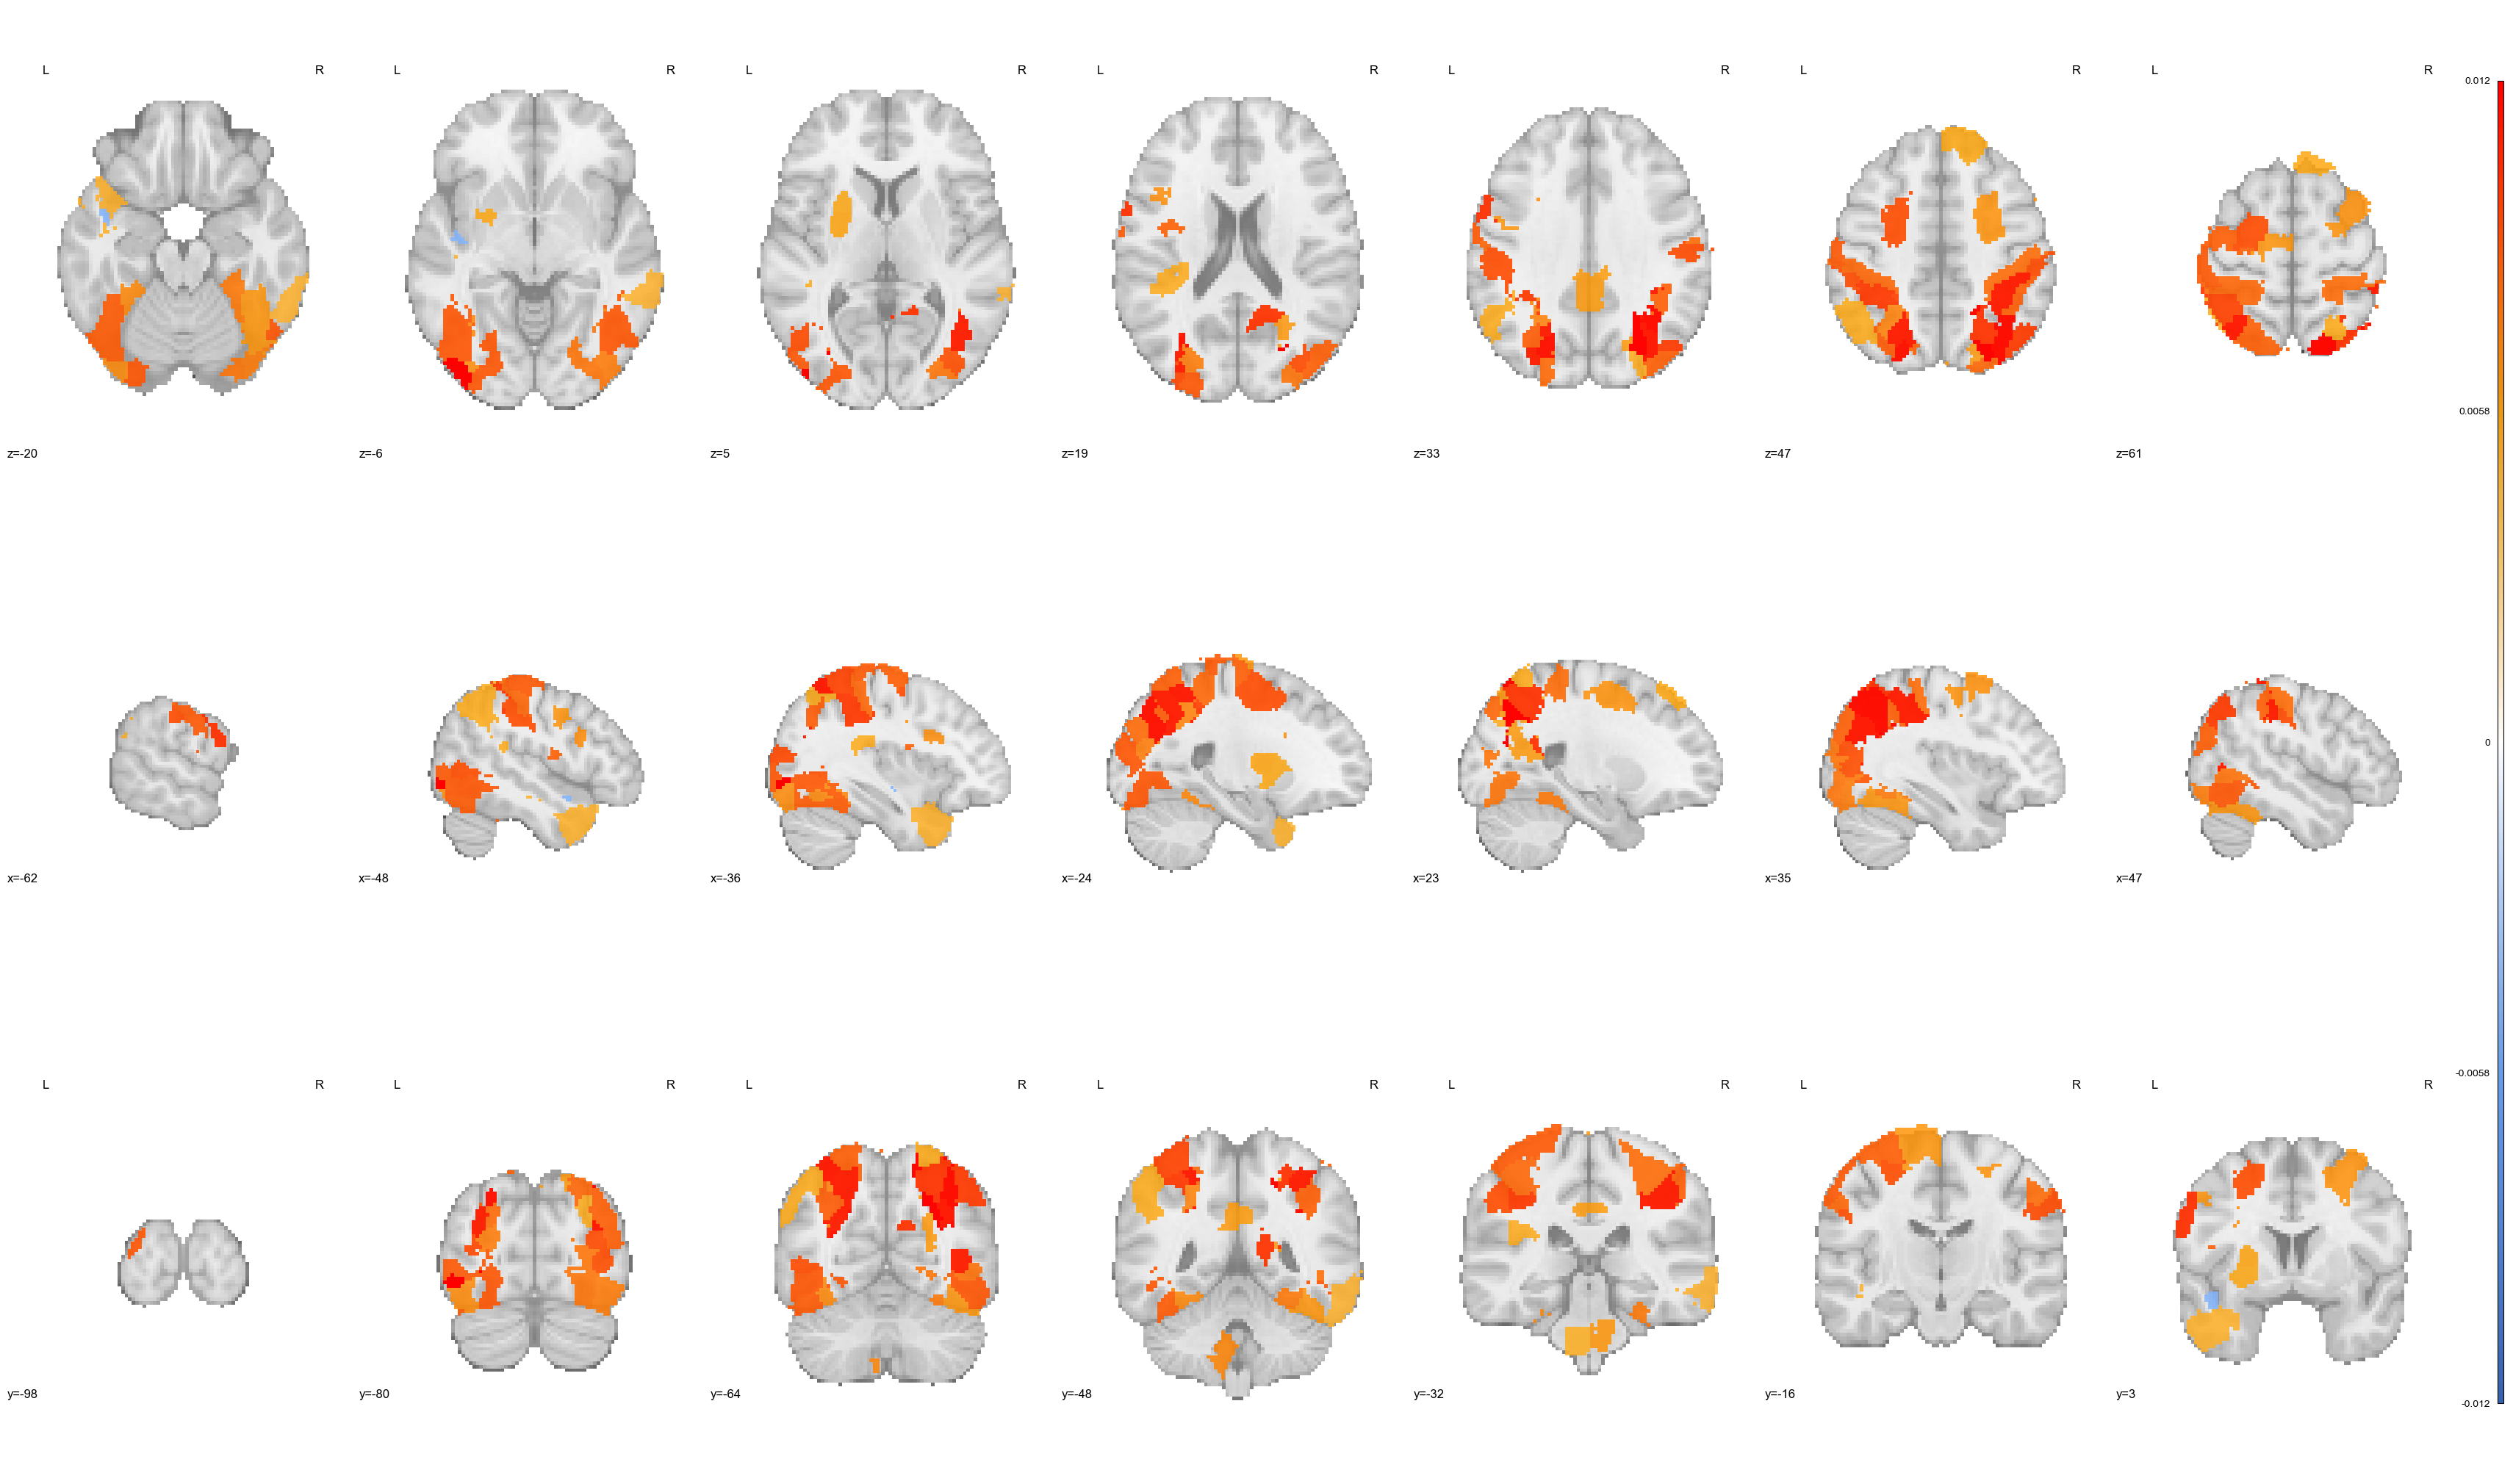

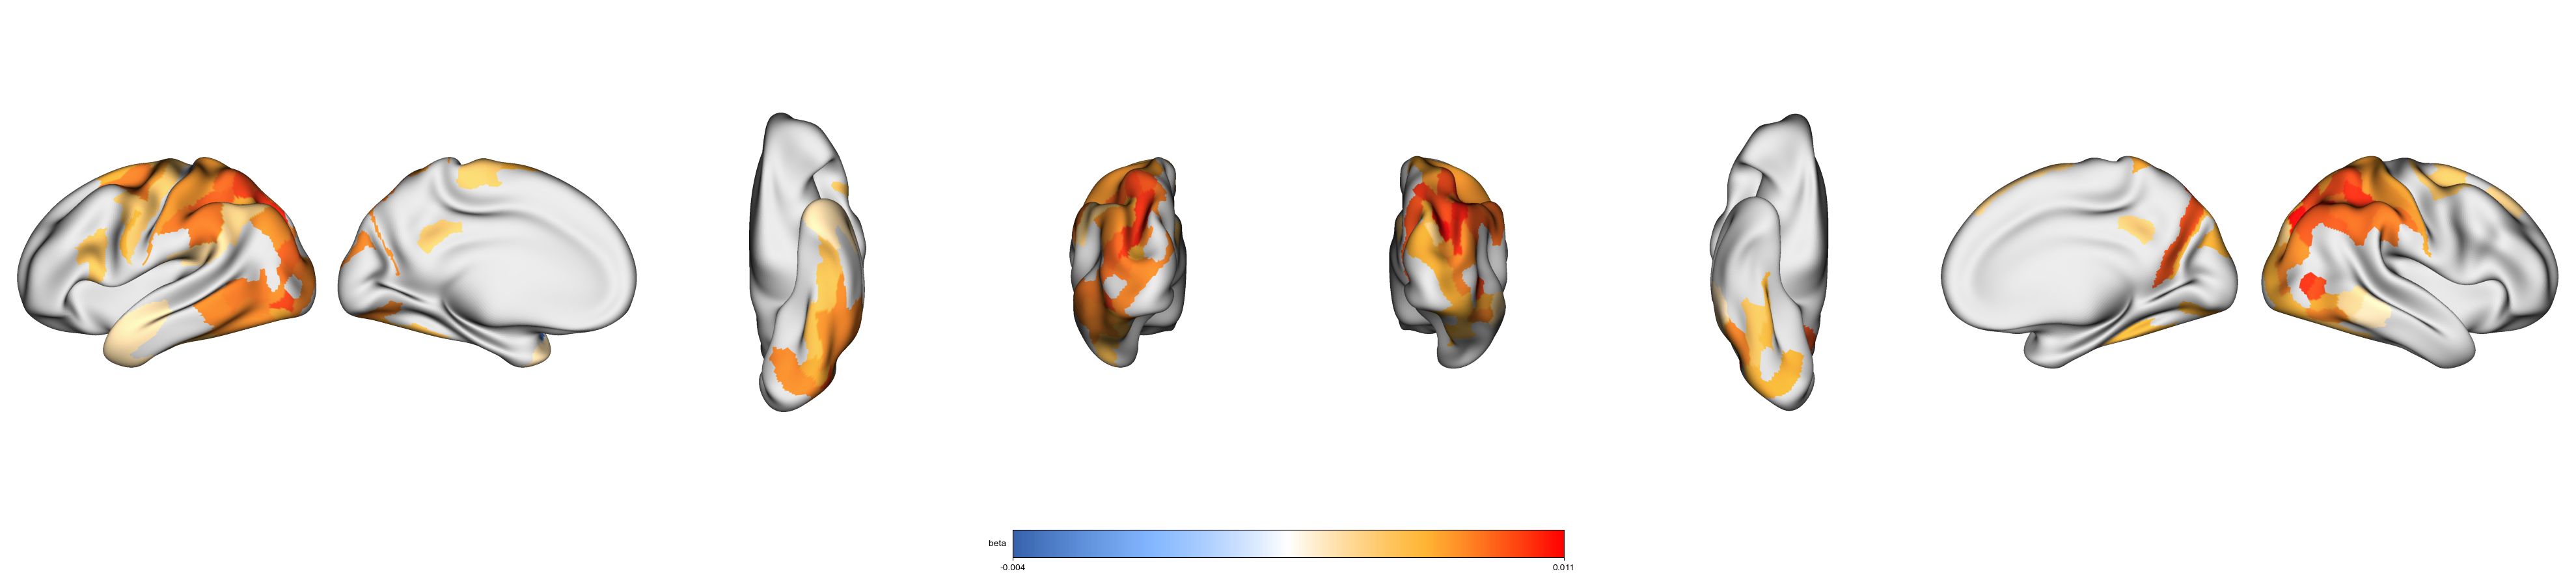

In [369]:
# convert results into MNI space
parc_ctx = Parcellater(parcellation=canlab2023, 
                   space='MNI152',
                   resampling_target='parcellation')
xcorr_mni = parc_ctx.inverse_transform(roi_xcorr)
plotting.plot_stat_map(xcorr_mni, display_mode='mosaic', cmap=cmap)

# project that into cifti parcel space
beta_fslr = mni152_to_fslr(
        xcorr_mni, fslr_density='32k', method='linear')
from neuromaps import transforms
from neuromaps.images import annot_to_gifti
hcplh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/lh.HCP-MMP1.annot')
hcprh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/rh.HCP-MMP1.annot')
HCP_fslr_lh = transforms.fsaverage_to_fslr(hcplh, hemi='L', target_density='32k', method='nearest')
HCP_fslr_rh = transforms.fsaverage_to_fslr(hcprh, hemi='R', target_density='32k', method='nearest')
HCP_fslr_rh_update = HCP_fslr_rh
HCP_fslr_rh_update[0].darrays[0].data = np.where(HCP_fslr_rh[0].agg_data() != 0, HCP_fslr_rh[0].agg_data() + 180, HCP_fslr_rh[0].agg_data())
hcp_glasser = (HCP_fslr_lh[0], HCP_fslr_rh_update[0])

# hcpmni = transforms.fslr_to_mni152_to_fslr(hcp_glasser, )
HCPparc = Parcellater(hcp_glasser, 'fsLR', resampling_target='parcellation')
singletrial_parc = HCPparc.fit_transform(beta_fslr, 'fsLR')
glasser_xcorr = HCPparc.inverse_transform(singletrial_parc)

fig = plot_brain_surfaces(image=glasser_xcorr, cbar_label=f'beta ', cmap=cmap)#color_range[beta_ind])

plt.show()

(97, 115, 97, 1)


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


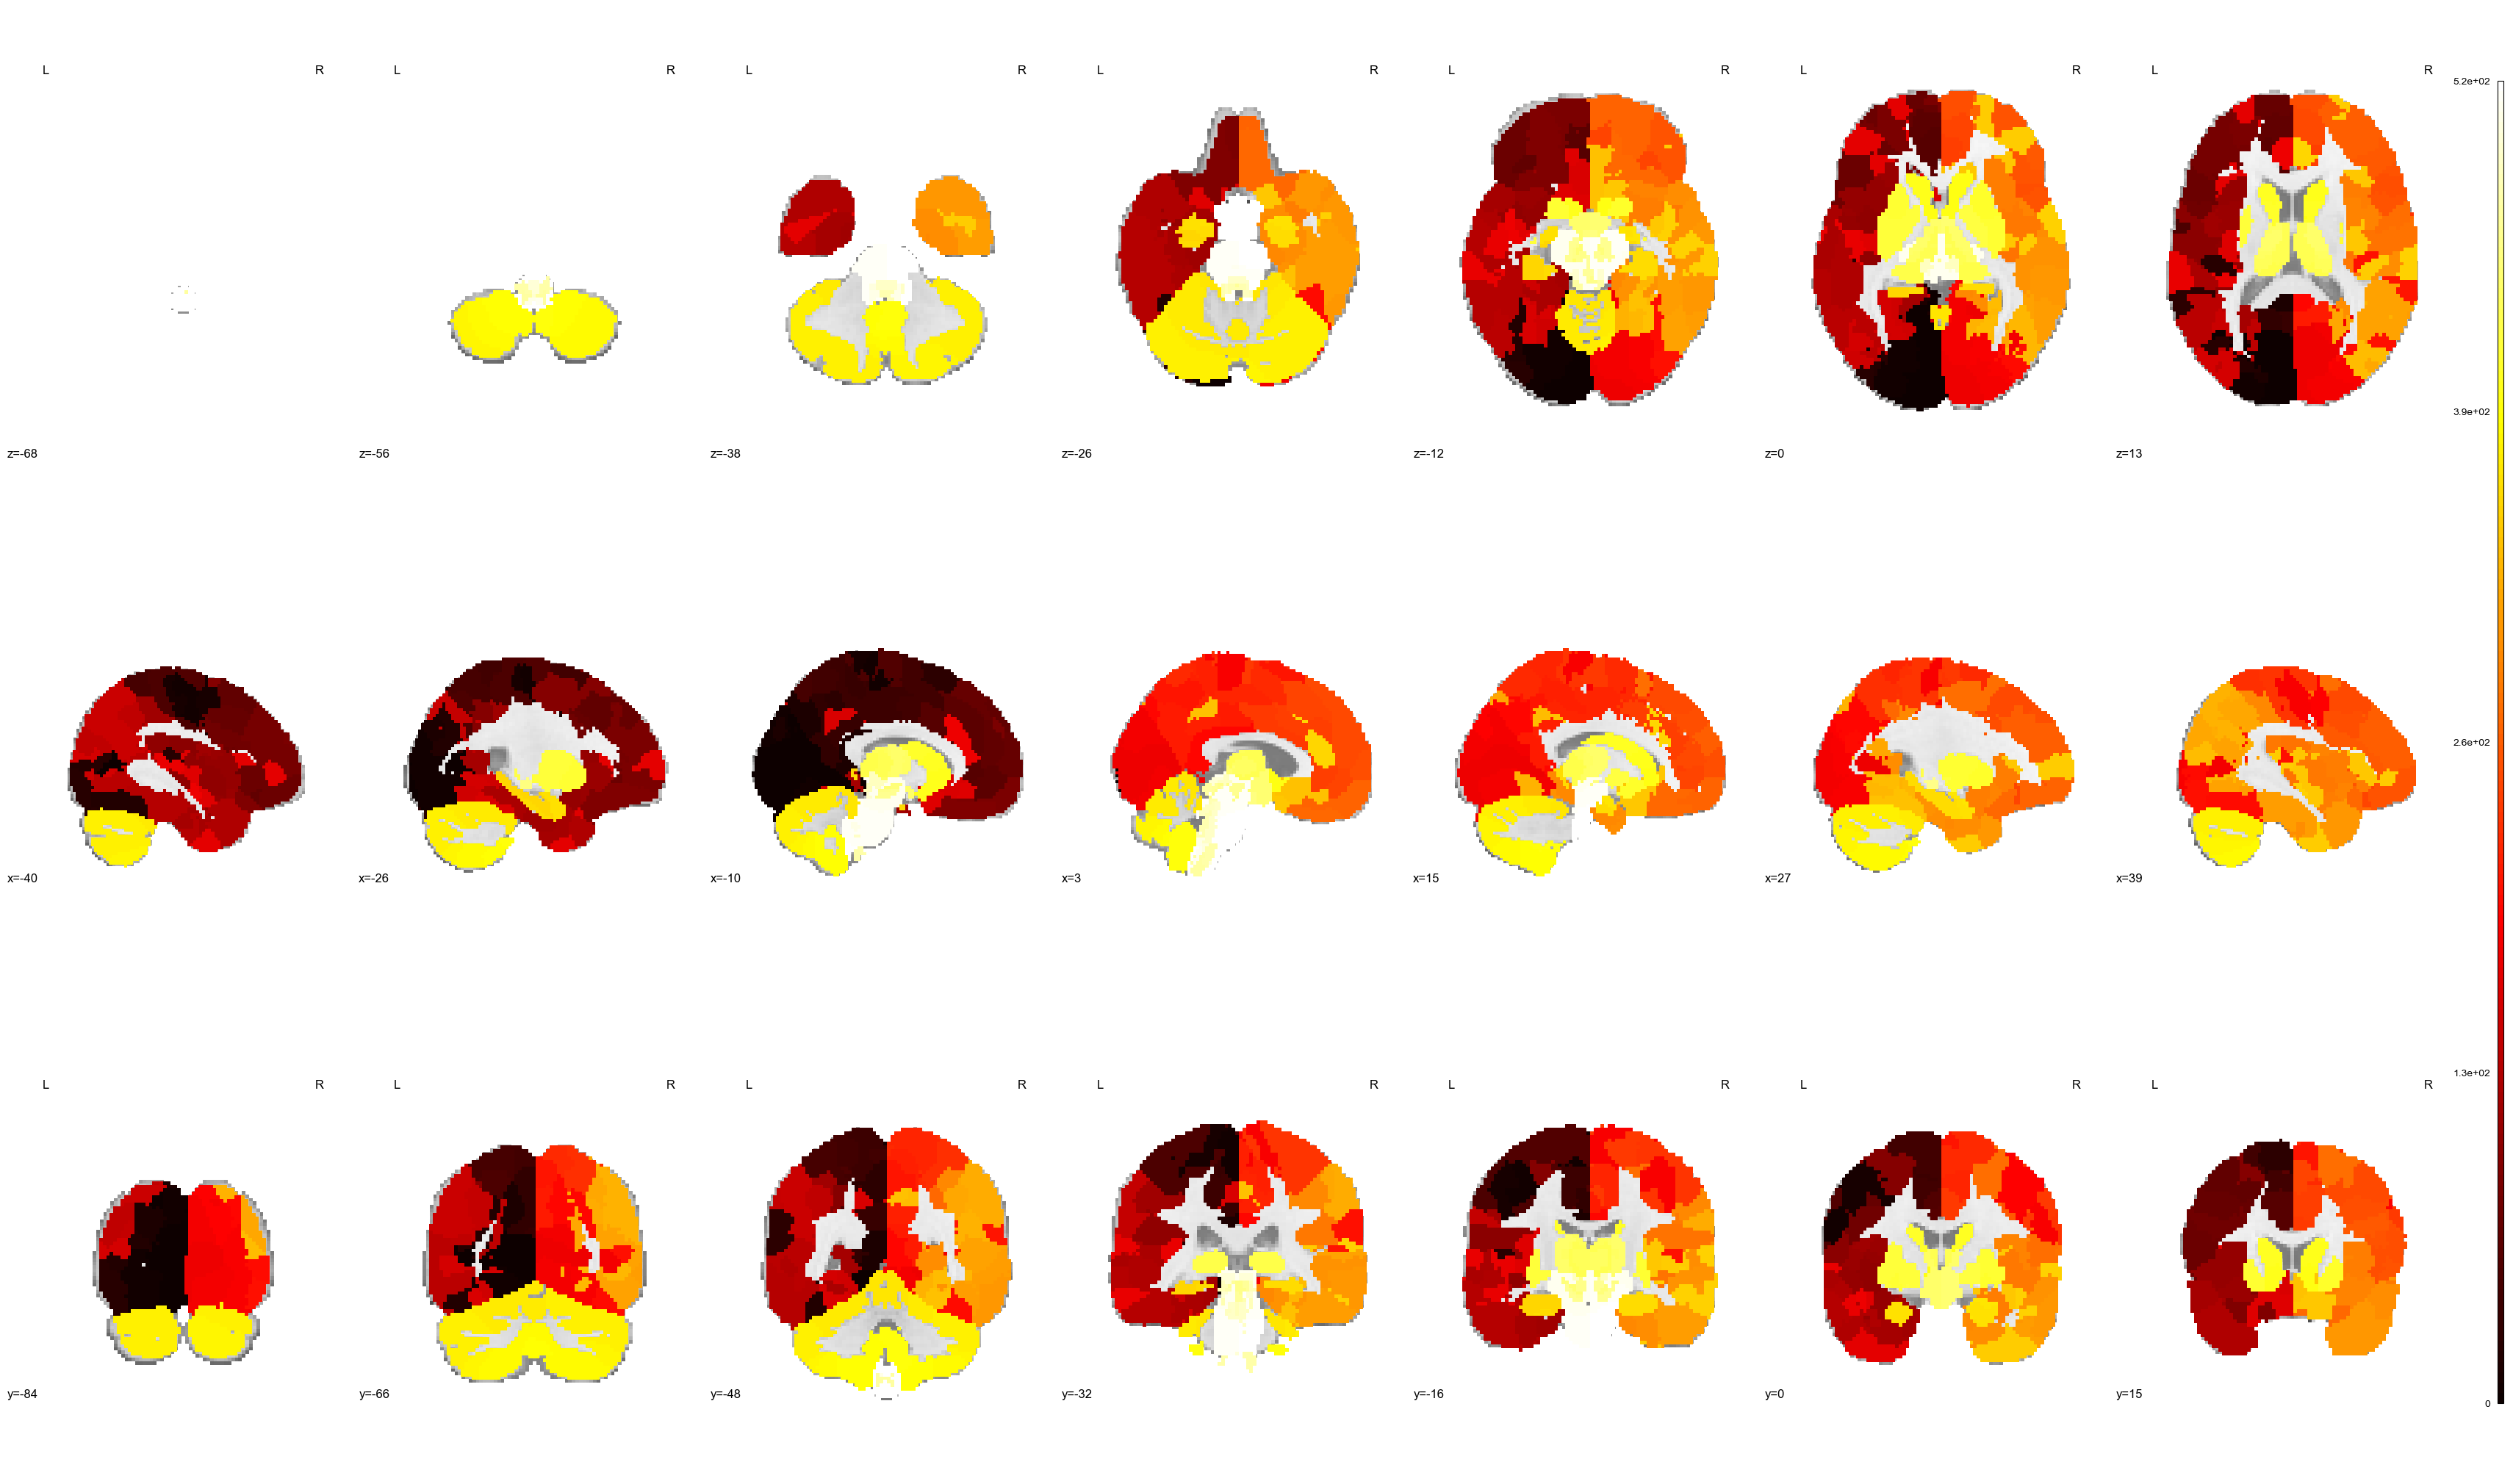

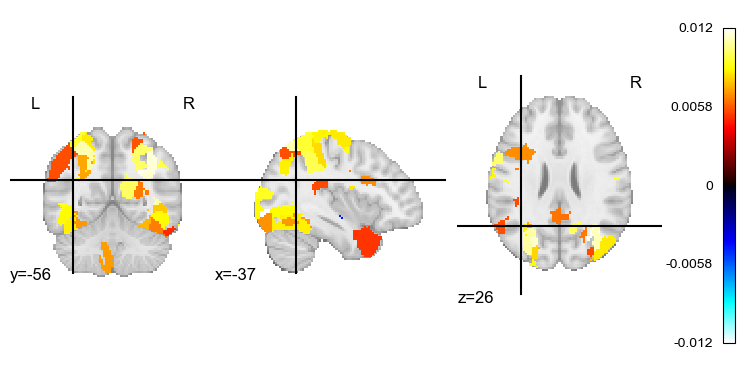

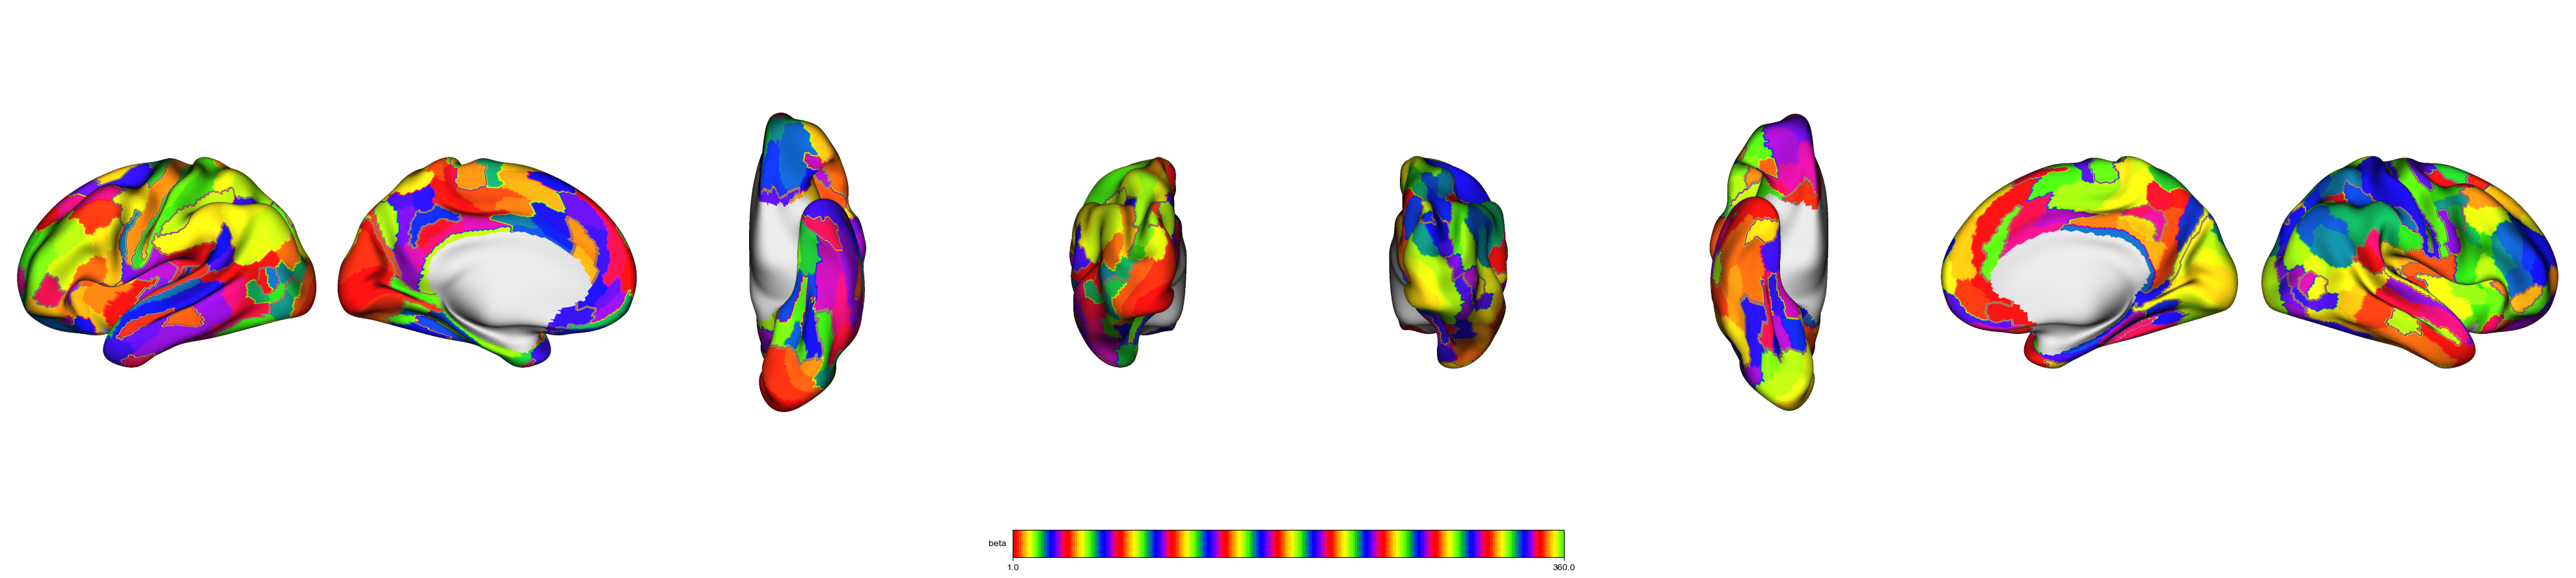

In [370]:
from neuromaps.transforms import mni152_to_fslr
canlab2023 = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.nii.gz'
canlab2023_list = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin2009cAsym_coarse_2mm.csv'
canlab2023_parcel = pd.read_csv(canlab2023_list)
parc_ctx = Parcellater(parcellation=canlab2023, 
                   space='MNI152')
                   #resampling_target='parcellation')
# plot atlas out
plotting.plot_stat_map(canlab2023, display_mode='mosaic')
roi_xcorr = group_level_stats_df['xcorr_sig']
# roi_xcorr = np.array(np.arange(358))
roictx = parc_ctx.inverse_transform(roi_xcorr)
print(f"{roictx.shape}")
plotting.plot_stat_map(roictx)
# join(atlas_dir, 'CANLab2023_MNI152NLin2009cAsym_coarse_2mm_cortex.nii.gz')
beta_fslr = mni152_to_fslr(
        canlab2023, fslr_density='32k', method='linear')
fig = plot_brain_surfaces(image=hcp_glasser, cbar_label=f'beta ', cmap='prism')#color_range[beta_ind])
plt.show()

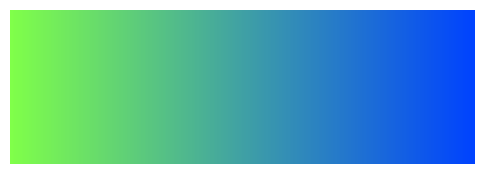

In [375]:
# Define the colors at specific points
colors = [
    # (-5.4, "#120041"),  # Start with blue at -1.9
    # (-3.6, "#2500fa"),
    # (-1.8, "#84c6fd"),  # Start with blue at -1.9
    (4, "#80ff4a"),    # Transition to white at 0
    # (4, "#fdbb2d"),
    # (5, "#09792c"),    # Start transitioning to red just after 0 towards 1.2
    (5, "#0043ff")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (-5.4, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-3.6, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (4, to_rgba("#80ff4a", alpha=1.0)),       # Fully opaque
    # (4, to_rgba("#fdbb2d", alpha=0.6)),   # 30% opacity
    # (6, to_rgba("#09792c", alpha=0.8)),   # 60% opacity
    (5, to_rgba("#0043ff", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(4,5, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
lag_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=lag_cmap)
ax.set_axis_off()

plt.show()


In [289]:
# # schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
# # parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
# # 

# roi_xcorr = group_level_stats_df['xcorr_sig']
# roi_xcorr = np.arange(524)
# roimni = parc.inverse_transform(roi_xcorr)

# maxval = np.max(roi_xcorr);    minval = np.min(roi_xcorr); sd = np.std(roi_xcorr)
# plotting.plot_stat_map(roimni, display_mode='mosaic')
# # fig = plot_brain_surfaces(image=roidata, cbar_label='Cross-correlation values', cmap=xcorr_cmap, color_range=(minval, maxval))
# plt.show()
# plt.savefig('Xcorr.png', dpi=300)  # Increase DPI for higher resolution



# group_level_stats_df['lag_sig'] = np.where(group_level_stats_df['corrected_p-value'] < .05,  group_level_stats_df['Time Lag (s)'], np.nan)
# roi_timelag = group_level_stats_df['lag_sig']
# roitimelag = parc.inverse_transform(roi_timelag)

# maxval = np.max(roi_timelag);    minval = np.min(roi_timelag); sd = np.std(roi_timelag)
# fig = plot_brain_surfaces(image=roitimelag, cbar_label='Cross-correlation values', cmap=lag_cmap, color_range=(minval, maxval))
# plt.show()
# plt.savefig('Xcorr_lag.png', dpi=300)  # Increase DPI for higher resolution


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


ValueError: Number of parcels in provided annotation files differs from size of parcellated data array.
    EXPECTED: 400 parcels
    RECEIVED: 524 parcels

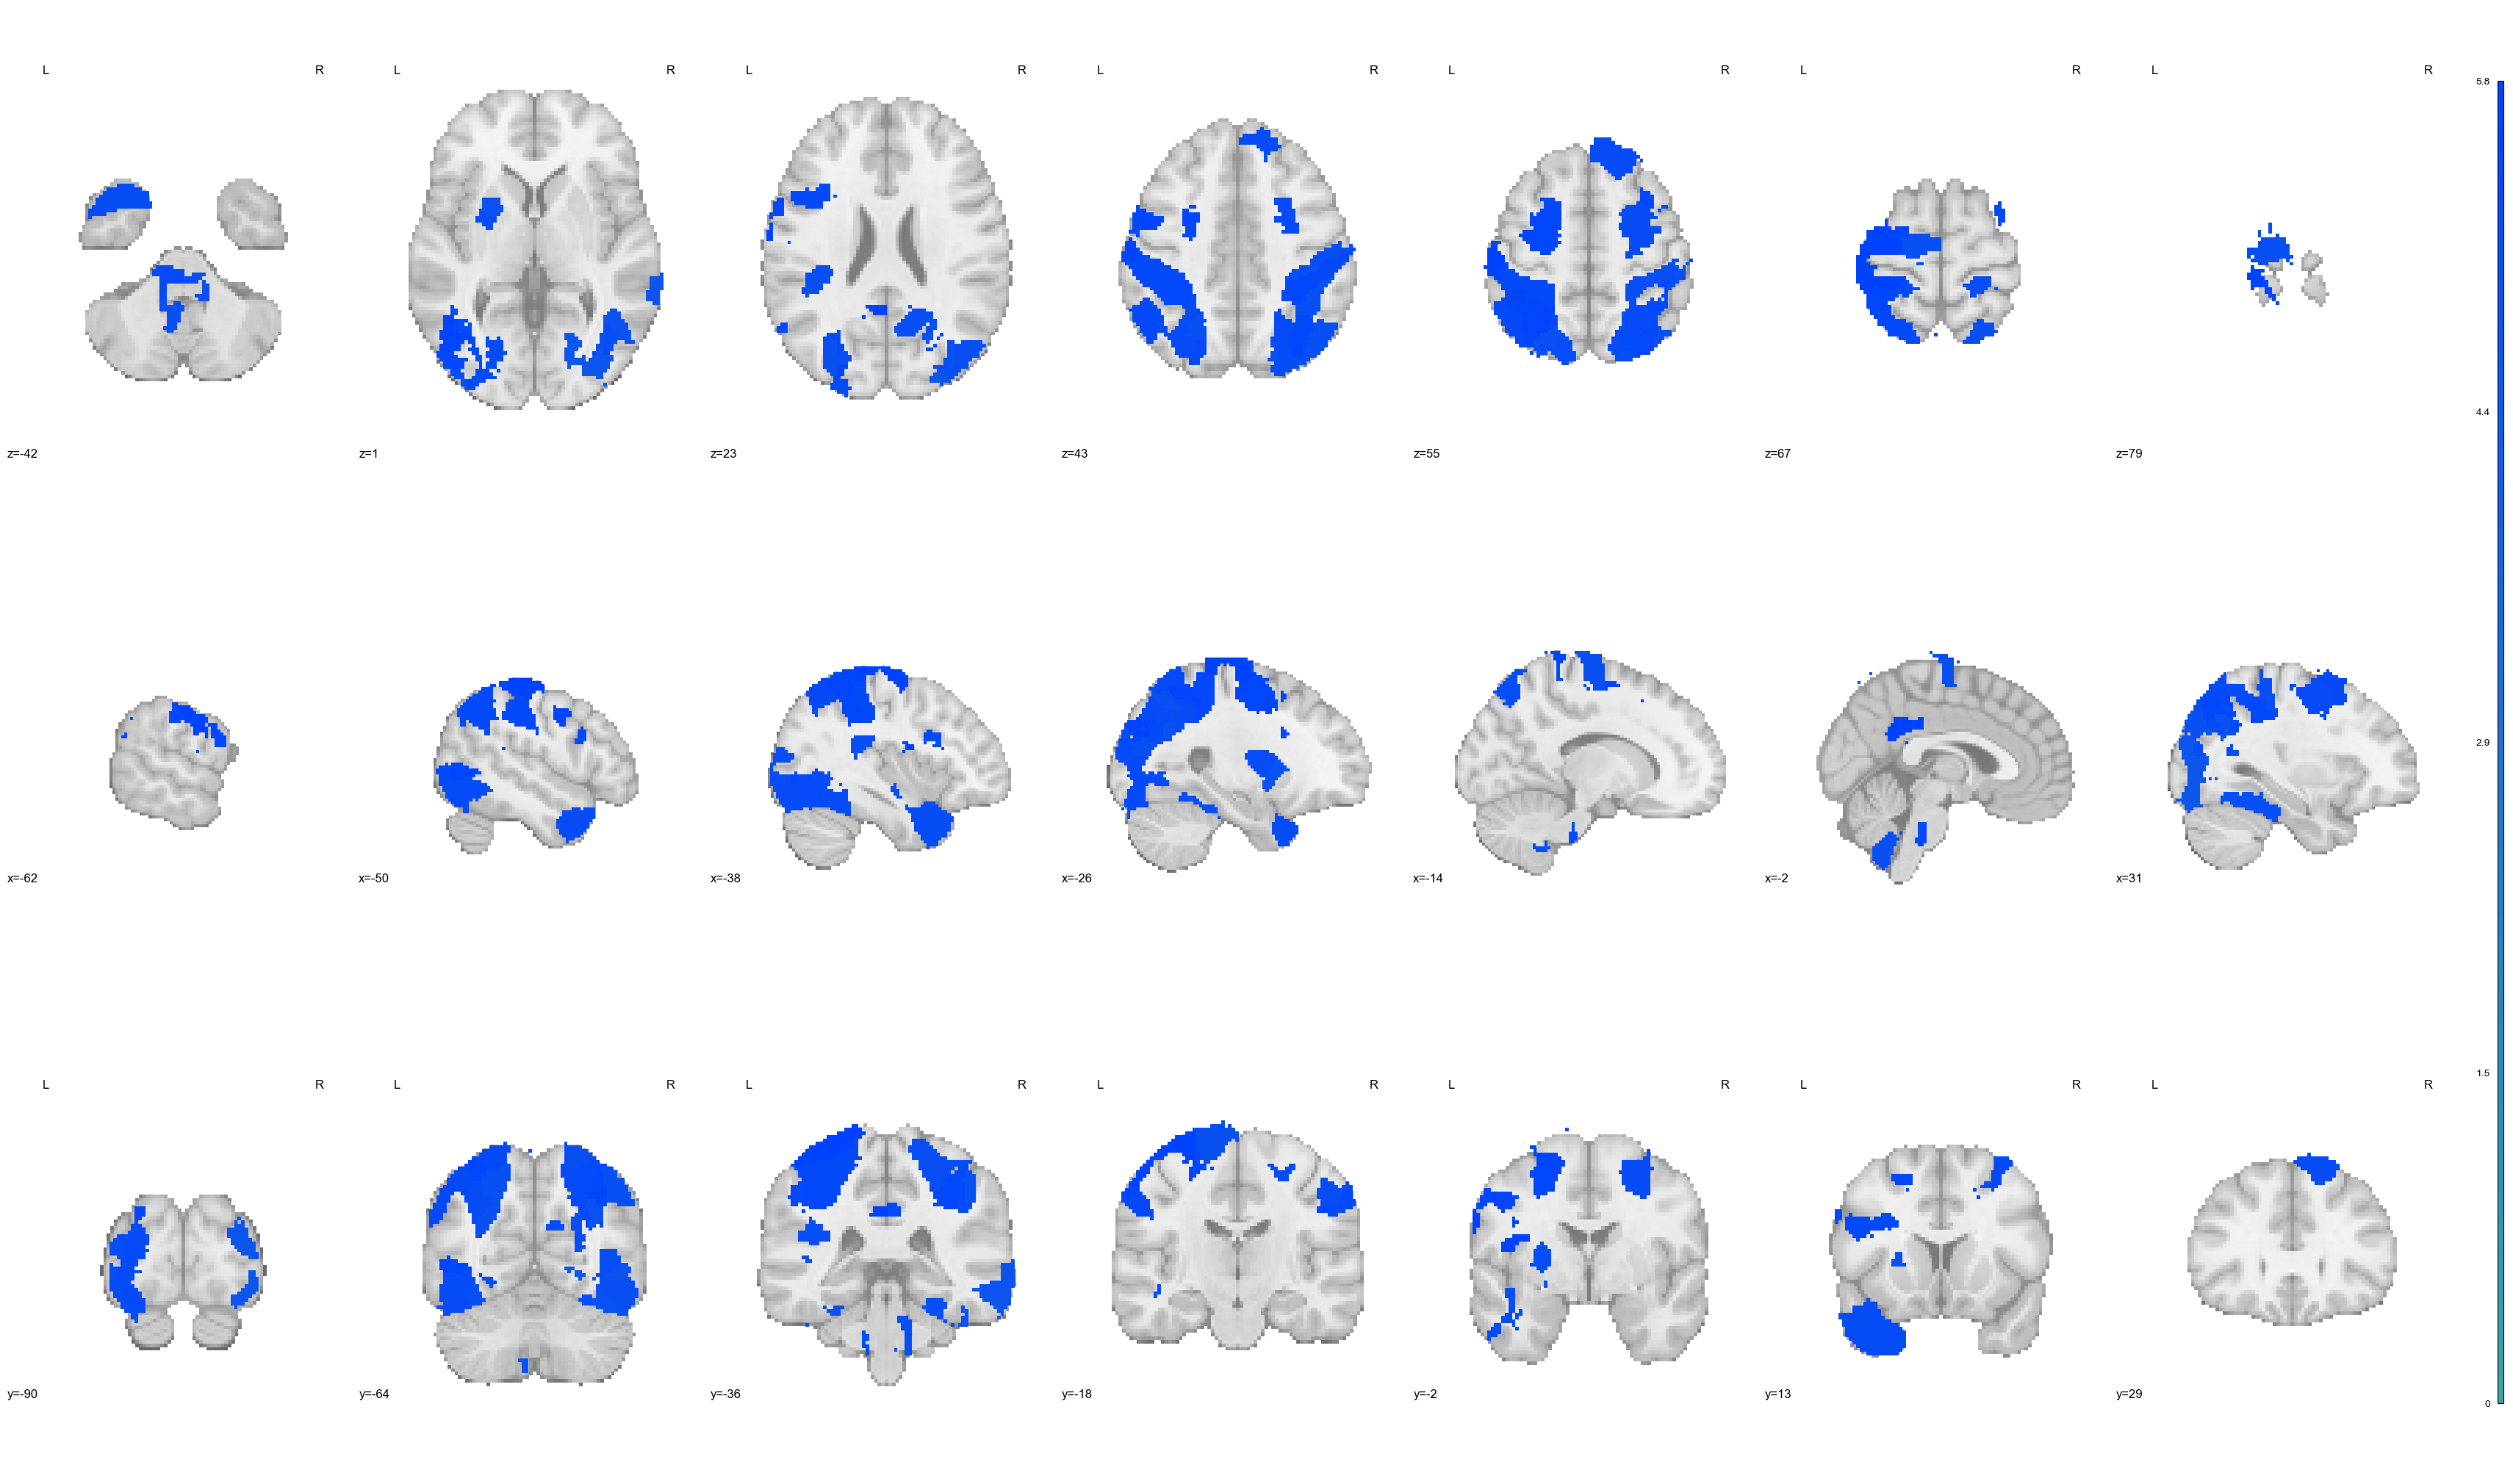

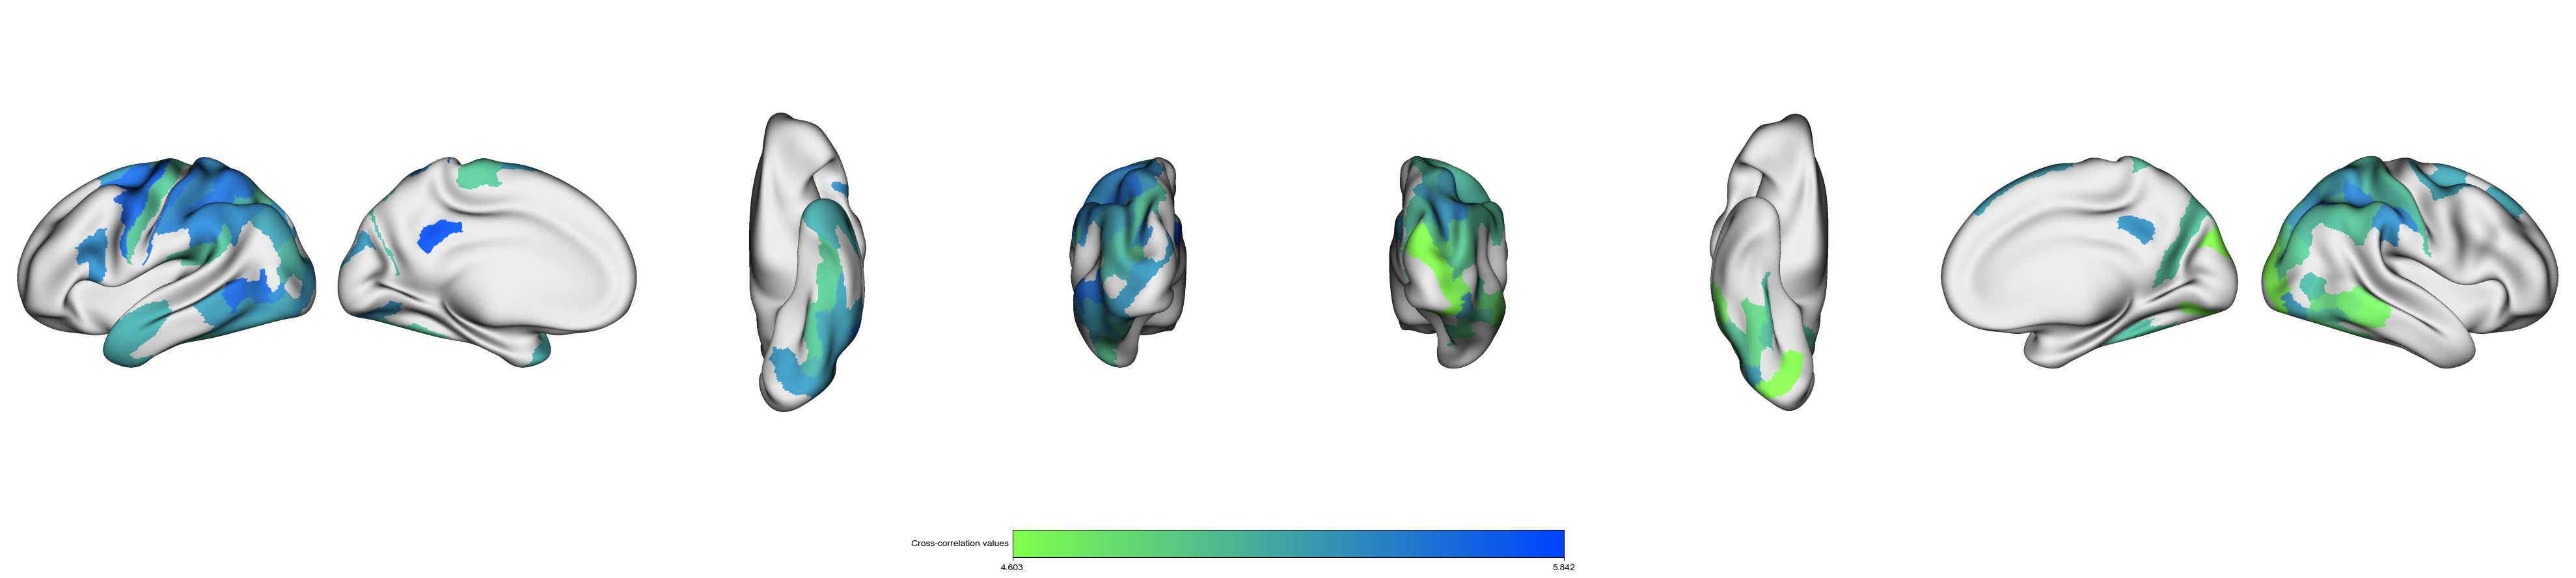

In [376]:
# convert results into MNI space
group_level_stats_df['lag_sig'] = np.where(group_level_stats_df['corrected_p-value'] < .05,  group_level_stats_df['Time Lag (s)'], np.nan)
roi_timelag = group_level_stats_df['lag_sig']


MNIparc = Parcellater(parcellation=canlab2023, 
                   space='MNI152',
                   resampling_target='parcellation')
MNIroitimelag = MNIparc.inverse_transform(roi_timelag)
plotting.plot_stat_map(MNIroitimelag, display_mode='mosaic', cmap=lag_cmap)

# project that into cifti parcel space
timelag_fslr = mni152_to_fslr(
        MNIroitimelag, fslr_density='32k', method='linear')

# HCP parcellator ______________________________________________________________
from neuromaps import transforms
from neuromaps.images import annot_to_gifti
hcplh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/lh.HCP-MMP1.annot')
hcprh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/rh.HCP-MMP1.annot')
HCP_fslr_lh = transforms.fsaverage_to_fslr(hcplh, hemi='L', target_density='32k', method='nearest')
HCP_fslr_rh = transforms.fsaverage_to_fslr(hcprh, hemi='R', target_density='32k', method='nearest')
HCP_fslr_rh_update = HCP_fslr_rh
HCP_fslr_rh_update[0].darrays[0].data = np.where(HCP_fslr_rh[0].agg_data() != 0, HCP_fslr_rh[0].agg_data() + 180, HCP_fslr_rh[0].agg_data())
hcp_glasser = (HCP_fslr_lh[0], HCP_fslr_rh_update[0])

# hcpmni = transforms.fslr_to_mni152_to_fslr(hcp_glasser, )
HCPparc = Parcellater(hcp_glasser, 'fsLR', resampling_target='parcellation')
singletrial_parc = HCPparc.fit_transform(timelag_fslr, 'fsLR')
glasser_timelag = HCPparc.inverse_transform(singletrial_parc)


maxval = np.max(roi_timelag);    minval = np.min(roi_timelag); sd = np.std(roi_timelag)
fig = plot_brain_surfaces(image=glasser_timelag, cbar_label='Cross-correlation values', cmap=lag_cmap, color_range=(minval, maxval))

plt.show()